# 🚢 Titanic Survival Prediction - A Binary Classification Excercise
By [Ignacio Di Bella](https://www.kaggle.com/ignaciodibella)

---

## 📖 Table of Contents
1. [Data Overview](#1.-🔍-Data-Overview)
2. [Exploratory Analysis](#2.-📊-Exploratory-Analysis)
3. [Insights](#3.-💡-Insights)
4. [Data Manipulation - Cleaning + Feature Engeneering](#4.-✨-Data-Manipulation---Cleaning-+-Feature-Engeneering)
5. [Modeling](#4.-📈-Modeling)
6. [Predictions](#6.-🔜-Predictions)
7. [Submission](#7.-📩-Submission)

In [1]:
# Importing Needed Libraries 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from scipy.stats import entropy

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. 🔍 Data Overview

In [2]:
#Loading Training & Test Data 

train_raw = pd.read_csv('/kaggle/input/titanic/train.csv') 
test = pd.read_csv('/kaggle/input/titanic/test.csv')

print('Train and Test Dataset Shapes:')
train_raw.shape, test.shape # Train data has one extra column with Survival Outcome (Target).

Train and Test Dataset Shapes:


((891, 12), (418, 11))

### Raw Features, Types, Missing Values And Data Summary

In [3]:
print('Train Data:')
train_raw.info()
print('\nTest Data:')
test.info()

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null 

In [4]:
print('Train Data:')
print(train_raw.isna().sum())

print('\nTest Data')
print(test.isna().sum())

Train Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


So far, 4 out of 11 features available for this study have some missing data (considering both train and test data). In particular, `Age` and `Cabin` features are frequently problematic.
Apart from that, `Embarked` and `Fare`should be taken into account also, as to decide what to do when data is not available in those dimensions.

This is important as the model won't be to work around a prediction if needed data is missing.

In [5]:
# Let's see how numeric data behaves - We'll check train data only as is the one we can manipulate
train_raw.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

# 2. 📊 Exploratory Analysis
In this section, we will begin by exploring the available features in the dataset. We will investigate how we can work with these features, create additional ones, form meaningful groups, and perform other necessary data manipulations.

After completing the exploratory analysis, we will formalize a pipeline for data cleaning and, if required, generate new features for the test dataset.

In [6]:
# Take a glance of how data is presented

train_raw.sample(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


PassengerId  Survived  Pclass  \
769          770         0       3   
210          211         0       3   
824          825         0       3   
331          332         0       1   
573          574         1       3   
213          214         0       2   
360          361         0       3   
400          401         1       3   
809          810         1       1   
813          814         0       3   

                                               Name     Sex   Age  SibSp  \
769                Gronnestad, Mr. Daniel Danielsen    male  32.0      0   
210                                  Ali, Mr. Ahmed    male  24.0      0   
824                    Panula, Master. Urho Abraham    male   2.0      4   
331                             Partner, Mr. Austen    male  45.5      0   
573                               Kelly, Miss. Mary  female   NaN      0   
213                     Givard, Mr. Hans Kristensen    male  30.0      0   
360                              Skoog, Mr. Wilhelm    male  40.0      1   
400                              Niskanen, Mr. Juha    male  39.0      0   
809  Chambers, Mrs. Norman Campbell (Bertha Griggs)  female  33.0      1   
813              Andersson, Miss. Ebba Iris Alfrida  female   6.0      4   

     Parch              Ticket     Fare Cabin Embarked  
769      0                8471   8.3625   NaN        S  
210      0  SOTON/O.Q. 3101311   7.0500   NaN        S  
824      1             3101295  39.6875   NaN        S  
331      0              113043  28.5000  C124        S  
573      0               14312   7.7500   NaN        Q  
213      0              250646  13.0000   NaN        S  
360      4              347088  27.9000   NaN        S  
400      0   STON/O 2. 3101289   7.9250   NaN        S  
809      0              113806  53.1000    E8        S  
813      2              347082  31.2750   NaN        S

Cabin feature will need some extra work to be of use.

### 2.1. How does gender influence survival chances?

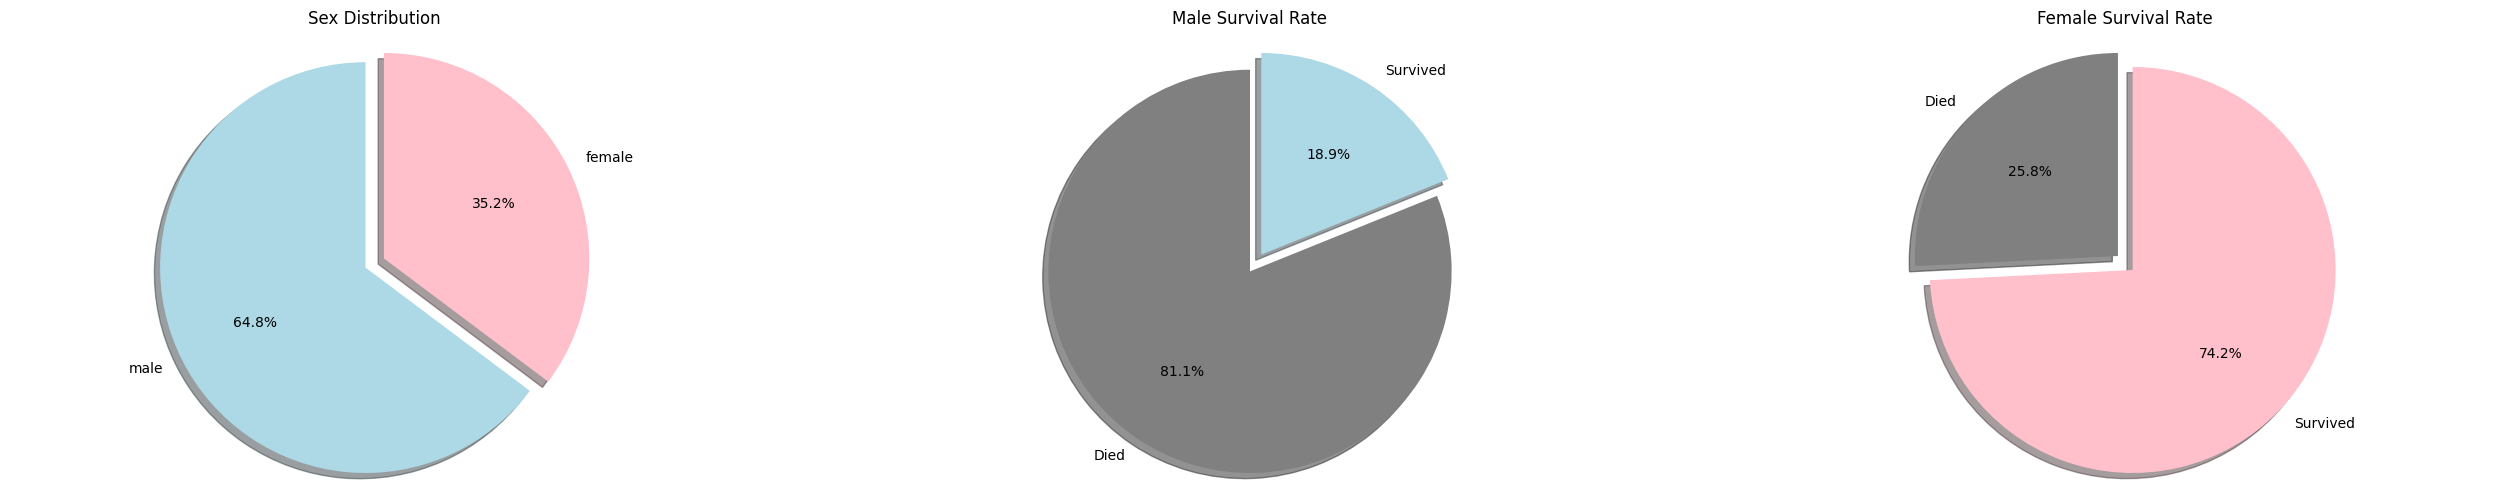

Female passengers seemed to have a better survival rate than male passengers when only considering gender as a predictor.
Most males died, while most females survived.


In [7]:
# Gender Analysis

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(32, 6)

#Sex distribution accross passengers - How many passengers per group are there
train_sex_distribution = train_raw["Sex"].value_counts()

ax[0].pie(train_sex_distribution.values, 
          labels=train_sex_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['lightblue', 'pink'])
ax[0].axis('equal')
ax[0].set_title('Sex Distribution')

#Survival rate across male passengers - Which is the proportion of males that died/survived
train_male_survival_distribution = train_raw[train_raw['Sex']=='male'].groupby('Survived')['Sex'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_male_survival_distribution.values, 
          labels=train_male_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightblue'])
ax[1].axis('equal')
ax[1].set_title("Male Survival Rate")

#Survival rate across female passengers - Which is the proportion of females that died/survived
train_male_survival_distribution = train_raw[train_raw['Sex']=='female'].groupby('Survived')['Sex'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_male_survival_distribution.values, 
          labels=train_male_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'pink'])
ax[2].axis('equal')
ax[2].set_title("Female Survival Rate")

plt.show()

# Insight
print('Female passengers seemed to have a better survival rate than male passengers when only considering gender as a predictor.')
print('Most males died, while most females survived.')

### 2.2. How does ticket class influence?

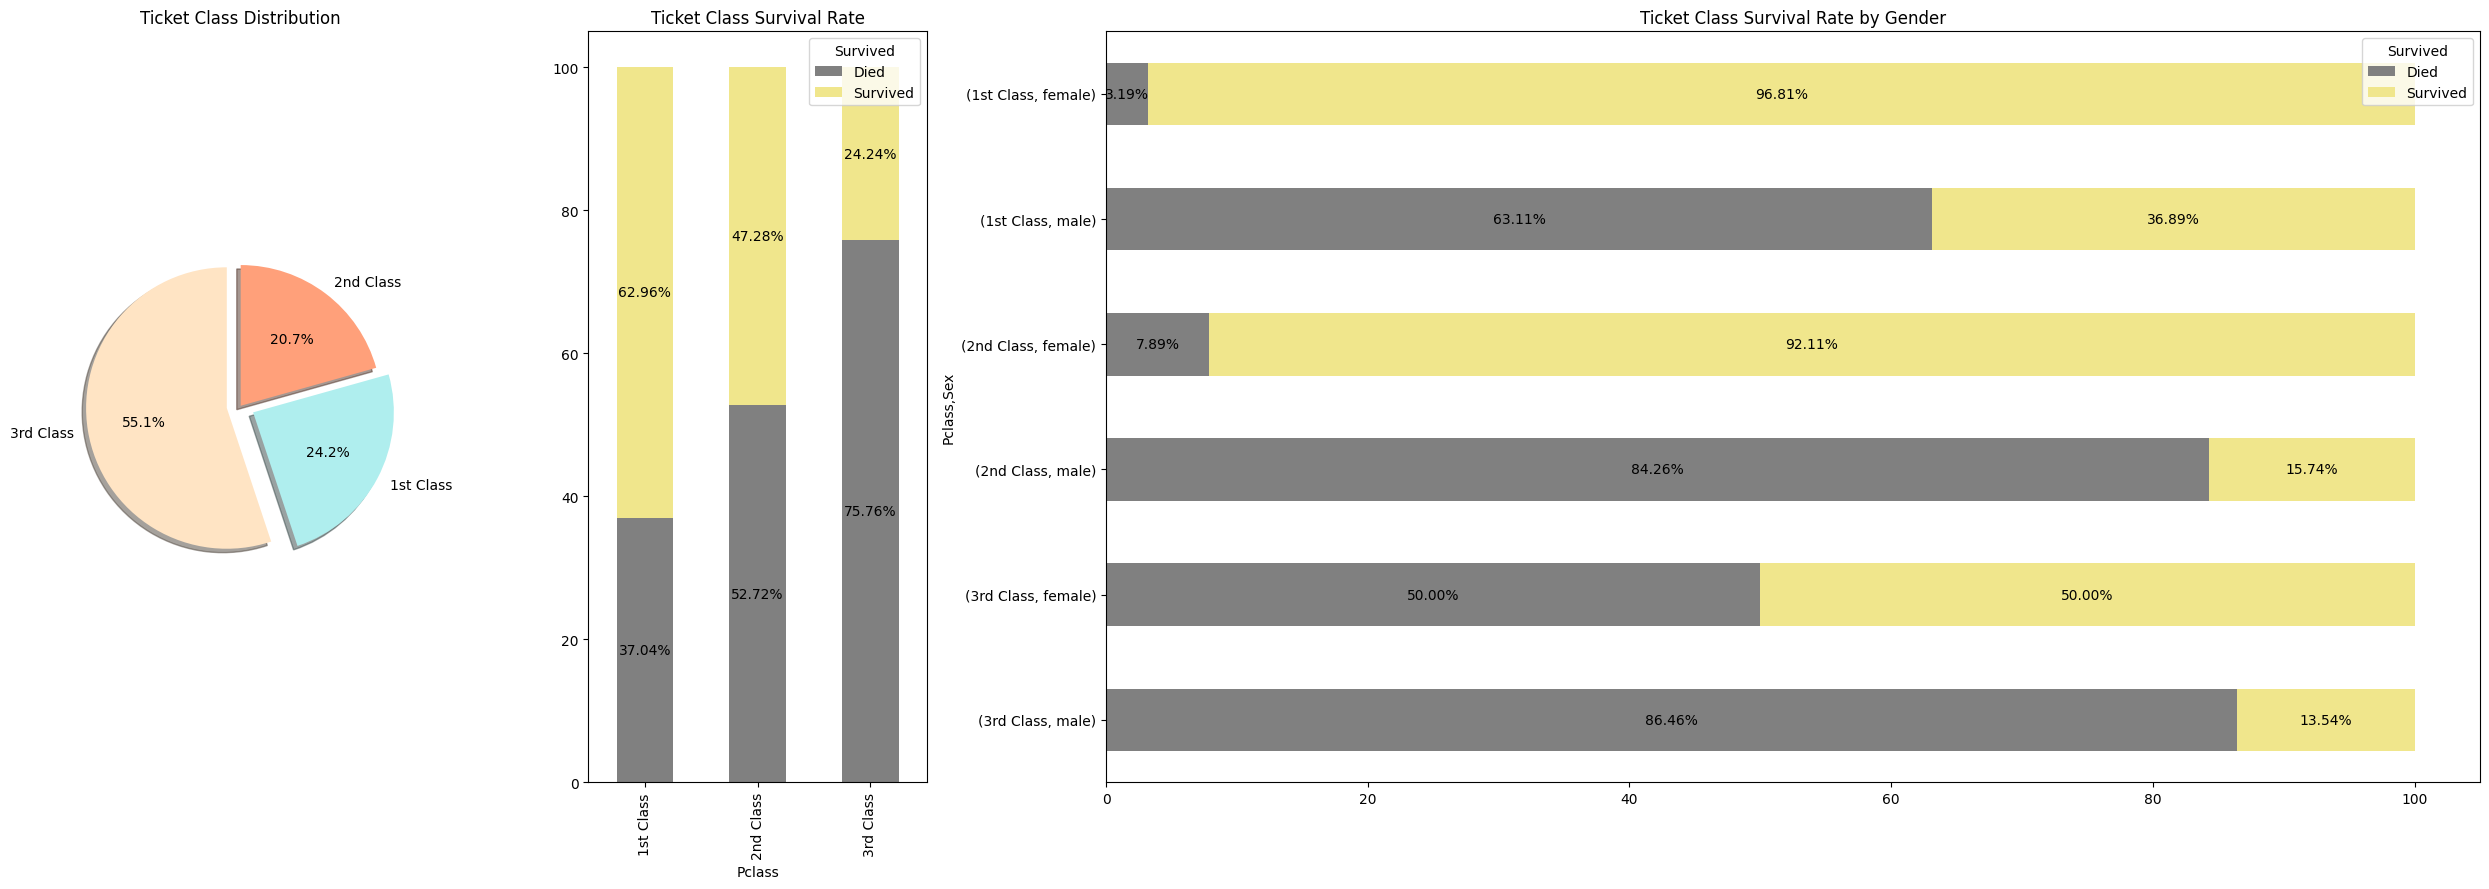

Apparently ticket class also influences sruvival chances (maybe as a result of position relative to the ship?).
Gender is still a good predictor.
First class males have better chances of surviving than those with lower class tickets (more than twice).


In [8]:
# Ticket Class Analysis

fig = plt.figure(figsize=(25, 9))
gs = fig.add_gridspec(1, 5)

# Ticket Class Distribution
ax0 = fig.add_subplot(gs[0, 0])
train_class_distribution = train_raw['Pclass'].value_counts().rename({1: '1st Class', 2:'2nd Class', 3:'3rd Class'})
ax0.pie(train_class_distribution.values, 
        labels=train_class_distribution.index, 
        shadow=True, 
        startangle=90, 
        autopct='%1.1f%%',
        explode=(0.1, 0.1, 0.0),
        colors=['bisque', 'paleturquoise', 'lightsalmon'])
ax0.axis('equal')
ax0.set_title("Ticket Class Distribution")

# Survival rate across ticket classes
ax1 = fig.add_subplot(gs[0, 1]) 
train_class_survival_rate = train_raw[['Pclass', 'Survived']].value_counts().unstack() 
train_class_survival_rate.index = train_class_survival_rate.index.map({1: '1st Class', 2: '2nd Class', 3: '3rd Class'}) 
train_class_survival_rate = train_class_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})
train_class_survival_rate = train_class_survival_rate.div(train_class_survival_rate.sum(axis=1), axis=0) * 100
bars = train_class_survival_rate.plot(kind='bar', stacked=True, color=['grey', 'khaki'], ax=ax1)
for container in bars.containers:
    ax1.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=10, color='black')
ax1.set_title("Ticket Class Survival Rate")

# Survival rate across ticket classes considering sex (3rd subplot takes 2/4 width)
ax2 = fig.add_subplot(gs[0, 2:])
train_class_sex_survival_rate = train_raw[['Pclass', 'Sex','Survived']].value_counts().unstack() 
train_class_sex_survival_rate = train_class_sex_survival_rate.rename(index={1: '1st Class', 2: '2nd Class', 3: '3rd Class'}, level=0)
train_class_sex_survival_rate = train_class_sex_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})
train_class_sex_survival_rate = train_class_sex_survival_rate.div(train_class_sex_survival_rate.sum(axis=1), axis=0) * 100
bars = train_class_sex_survival_rate.sort_index(ascending=False).plot(kind='barh', stacked=True, color=['grey', 'khaki'], ax=ax2)
for container in bars.containers:
    ax2.bar_label(container, fmt='%.2f%%', label_type='center', fontsize=10, color='black')
ax2.set_title("Ticket Class Survival Rate by Gender")

plt.tight_layout()
plt.show()

print('Apparently ticket class also influences sruvival chances (maybe as a result of position relative to the ship?).')
print('Gender is still a good predictor.')
print('First class males have better chances of surviving than those with lower class tickets (more than twice).')

### 2.3. Is age something that affects? Is being younger or middled-aged better? Old passengers had less survival chances?

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


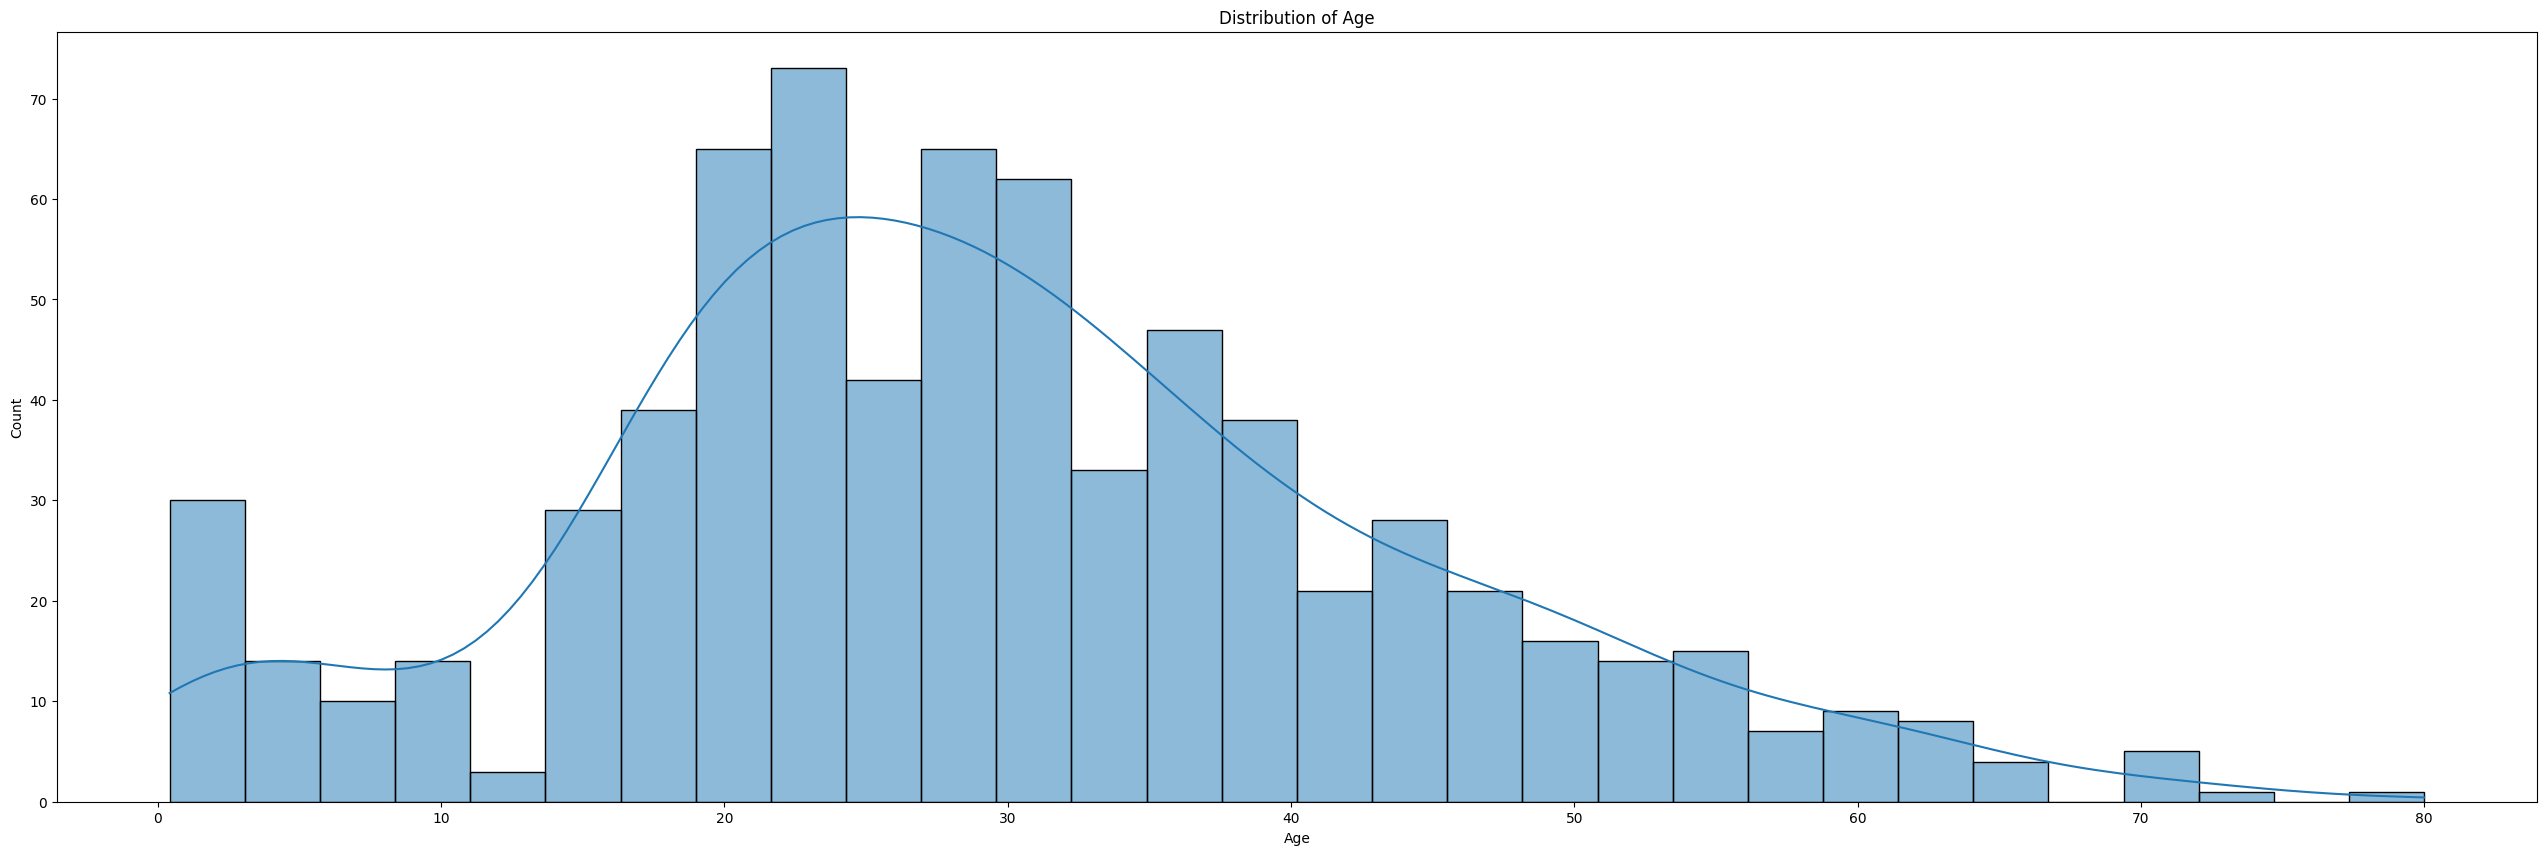

In [9]:
# Age Analysis - Distribution

plt.figure(figsize=(32, 10))
sns.histplot(train_raw['Age'].dropna(), kde=True, bins=30)
plt.title(f'Distribution of Age')
plt.show()

Some ideas on how to bin/group age ranges:

<ipython-input-10-b4e81f24f678>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_age_survival_rate = train_raw.groupby(['AgeBin', 'Survived']).size().unstack().dropna()


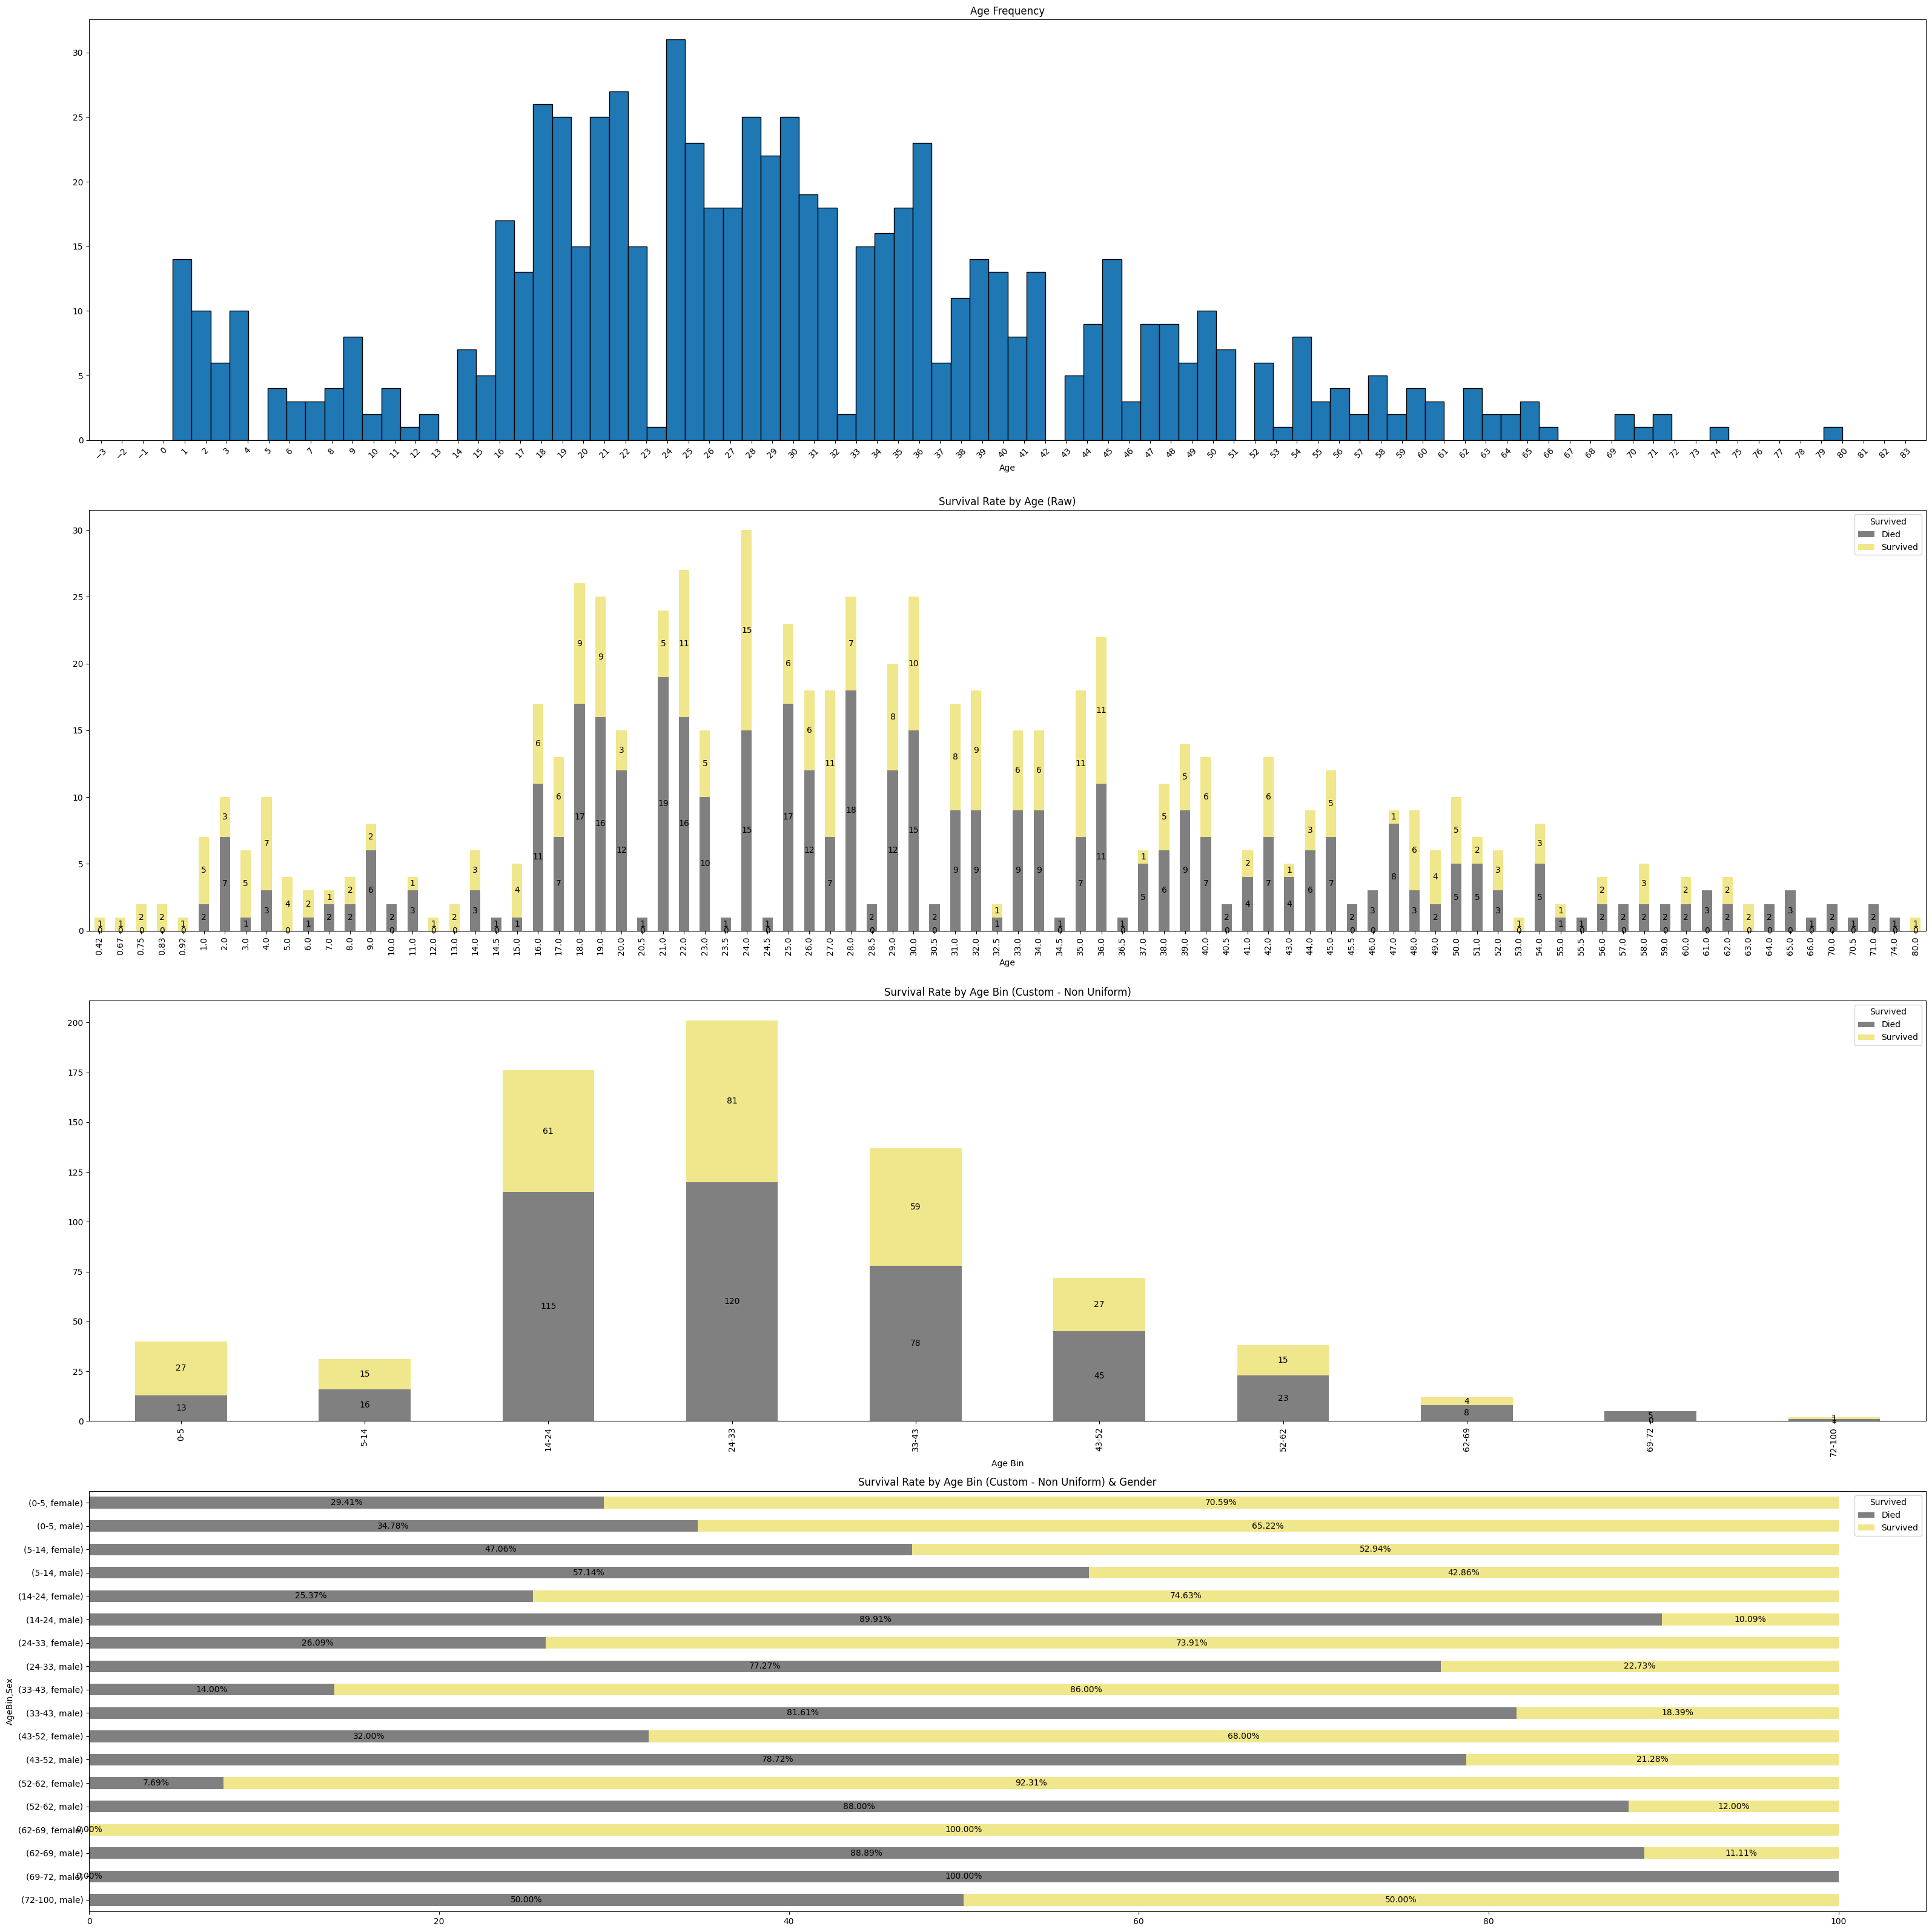

Gender and Age are intresing when combined


In [10]:
# Age Analysis - Survival

fig, ax = plt.subplots(4, 1)
fig.set_size_inches(32, 32)

# Age Frequency
train_age_counts = train_raw['Age'].value_counts().sort_index()
ax[0].hist(train_age_counts.index.repeat(train_age_counts.values), bins=len(train_age_counts.index), edgecolor="black")
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].tick_params(axis='x', rotation=45) 
ax[0].set_title("Age Frequency")
ax[0].set_xlabel("Age")

# Survival observations across different ages (raw - without binning)
train_age_survival_rate = train_raw[['Age', 'Survived']].value_counts().unstack()
train_age_survival_rate = train_age_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})
bars = train_age_survival_rate.plot(kind='bar', stacked=True, color=['grey', 'khaki'], ax=ax[1])

for container in bars.containers:
    ax[1].bar_label(container, label_type='center', fontsize=10, color='black')
ax[1].set_title("Survival Rate by Age (Raw)")
ax[1].set_xlabel("Age")


age_bins = [0, 5, 14, 24, 33, 43, 52, 62, 69, 72, 100]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]
train_raw['AgeBin'] = pd.cut(train_raw['Age'], bins=age_bins, labels=age_labels, right=False)
train_age_survival_rate = train_raw.groupby(['AgeBin', 'Survived']).size().unstack().dropna()
train_age_survival_rate = train_age_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})

bars = train_age_survival_rate.plot(kind='bar', stacked=True, color=['grey', 'khaki'], ax=ax[2])
for container in bars.containers:
    ax[2].bar_label(container, fmt='%d', label_type='center', fontsize=10, color='black')
ax[2].set_title("Survival Rate by Age Bin (Custom - Non Uniform)")
ax[2].set_xlabel("Age Bin")


train_age_sex_survival_rate = train_raw[['AgeBin', 'Sex','Survived']].value_counts().unstack() 
train_age_sex_survival_rate = train_age_sex_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})
train_age_sex_survival_rate = train_age_sex_survival_rate.div(train_age_sex_survival_rate.sum(axis=1), axis=0) * 100
bars = train_age_sex_survival_rate.sort_index(ascending=False).plot(kind='barh', stacked=True, color=['grey', 'khaki'], ax=ax[3])
for container in bars.containers:
    ax[3].bar_label(container, fmt='%.2f%%', label_type='center', fontsize=10, color='black')
ax[3].set_title("Survival Rate by Age Bin (Custom - Non Uniform) & Gender")


plt.tight_layout()
plt.show()

print('Gender and Age are intresing when combined')

What if we group age ranges in homogeneus groups instead?

<ipython-input-11-0be8b4021583>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_age_hom_survival_rate = train_raw.groupby(['AgeBinHom', 'Survived']).size().unstack().dropna()


Text(0.5, 0, 'Age Bin')

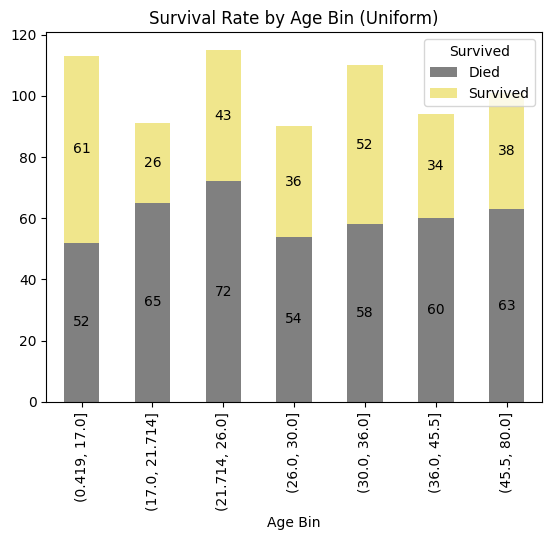

In [11]:
# Age Analysis - Survival
train_raw['AgeBinHom'] = pd.qcut(train_raw['Age'], 7)

fig, ax = plt.subplots(1, 1)

train_age_hom_survival_rate = train_raw.groupby(['AgeBinHom', 'Survived']).size().unstack().dropna()
train_age_hom_survival_rate = train_age_hom_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})

bars = train_age_hom_survival_rate.plot(kind='bar', stacked=True, color=['grey', 'khaki'], ax=ax)
for container in bars.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=10, color='black')
ax.set_title("Survival Rate by Age Bin (Uniform)")
ax.set_xlabel("Age Bin")

It's intresting how the group from 17 to almost 22 had little chances of surviving.

### 2.4. Is there value in knowing where the passengers embarked?
#### On the surface, the location where passengers embarked may not seem like a strong predictor of survival, as it does not have a direct connection to the accident itself. However, the embarkation point could provide valuable insights when considered in the context of other factors, such as socioeconomic level, or class as well as some sociodemographic data covered by it.

Text(0.5, 1.0, 'Southampton Bording Survival Rate')

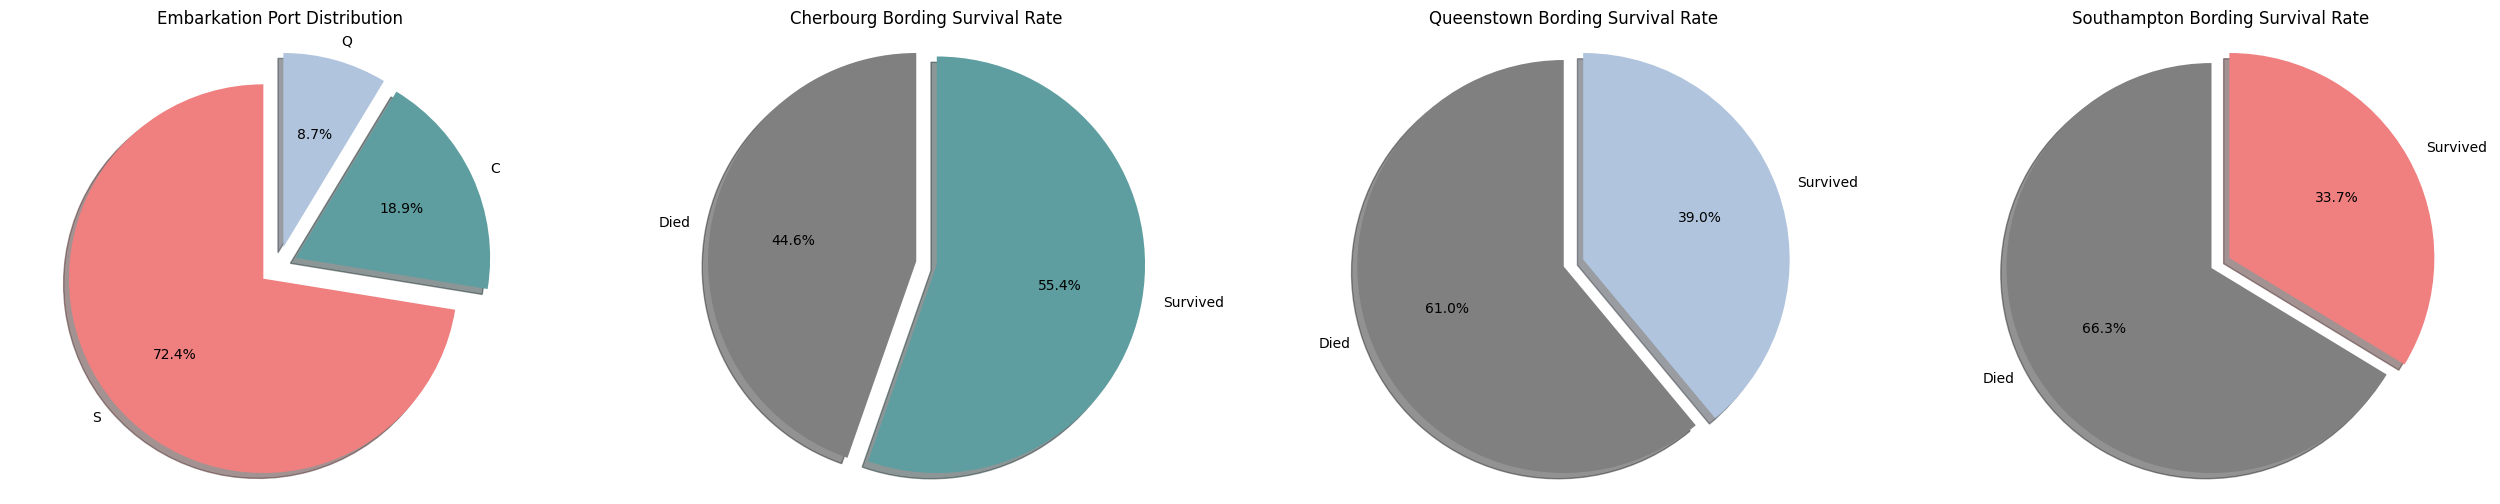

In [12]:
# Port of Embarkation Analysis

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(32, 6)

#Embarkation Port Distribution
train_embarked_distribution = train_raw["Embarked"].value_counts()

ax[0].pie(train_embarked_distribution.values, 
          labels=train_embarked_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0.1, 0.1, 0.1),
          colors=['lightcoral', 'cadetblue', 'lightsteelblue'])
ax[0].axis('equal')
ax[0].set_title('Embarkation Port Distribution')

#Survival rate across Cherbourg bording passengers
train_cher_survival_distribution = train_raw[train_raw['Embarked']=='C'].groupby('Survived')['Embarked'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_cher_survival_distribution.values, 
          labels=train_cher_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'cadetblue'])
ax[1].axis('equal')
ax[1].set_title("Cherbourg Bording Survival Rate")

#Survival rate across Queenstown bording passengers
train_queen_survival_distribution = train_raw[train_raw['Embarked']=='Q'].groupby('Survived')['Embarked'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_queen_survival_distribution.values, 
          labels=train_queen_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[2].axis('equal')
ax[2].set_title("Queenstown Bording Survival Rate")

#Survival rate across Southampton bording passengers
train_south_survival_distribution = train_raw[train_raw['Embarked']=='S'].groupby('Survived')['Embarked'].count().rename({0: 'Died', 1:'Survived'})

ax[3].pie(train_south_survival_distribution.values, 
          labels=train_south_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[3].axis('equal')
ax[3].set_title("Southampton Bording Survival Rate")

### 2.5. Does a Passenger's Title Impact Survival?

Remember that gender is a big predictor and as titles without homologation are gender specific, masculuine titles with low nobelty level are expected to have worst survival rate than female's


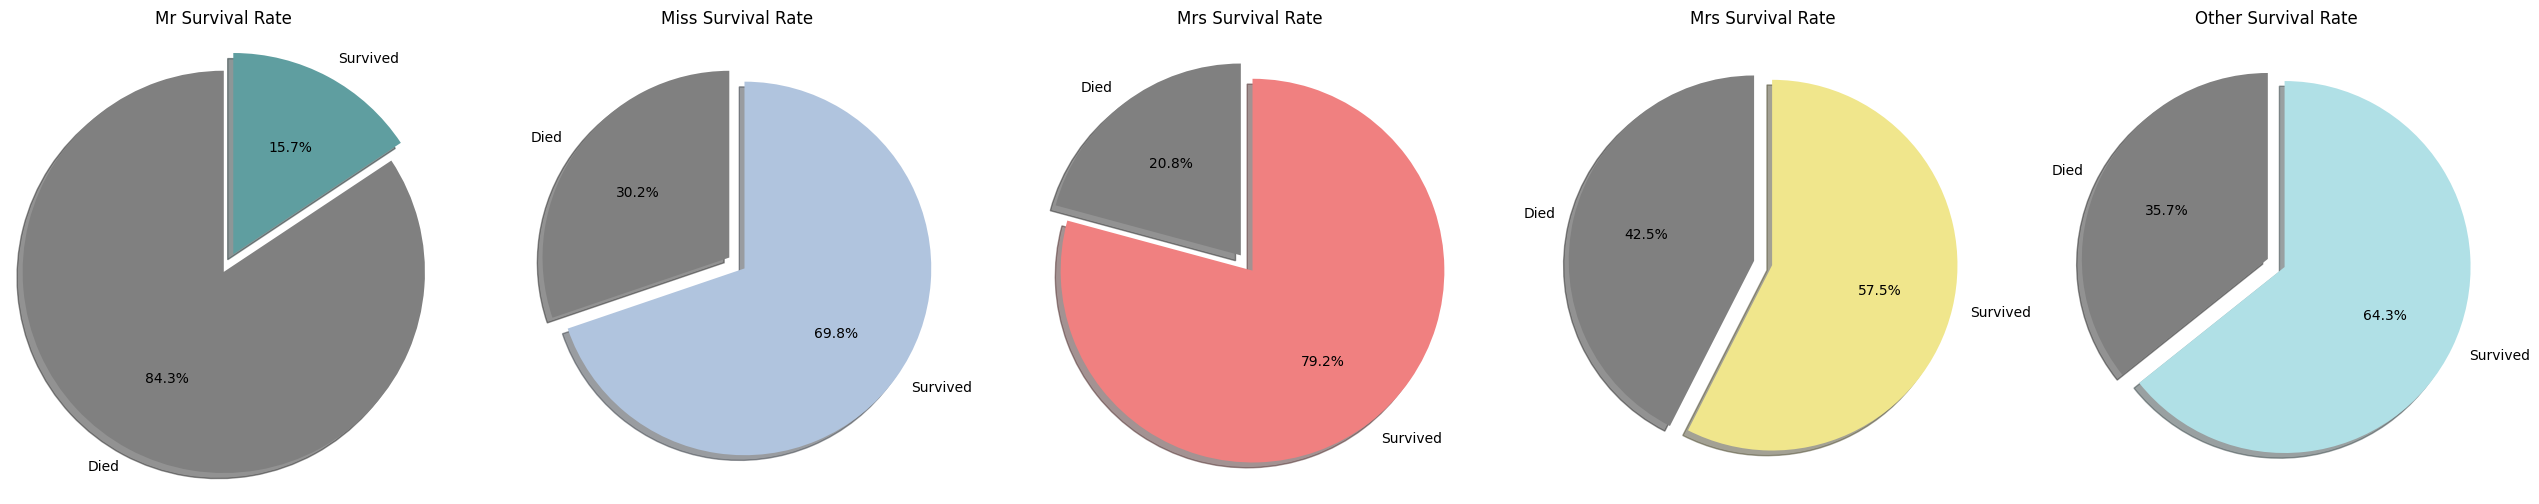

In [13]:
#Title Analysis

train_raw['Title_'] = train_raw.Name.str.split(', ').str[1].str.split('.').str[0] # Obtaining passenger's title from their names.

# Some titles are not that common, so we will homologate them into some categories and classify the rest as 'Others'. Keep in mind that most of them are gender specific.
title_mapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Dr": "Dr",
    "Rev": "Rev"}

train_raw['Title'] = train_raw['Title_'].map(title_mapping).fillna('Other')
train_raw.drop('Title_', axis=1, inplace=True)

# Does removing the gender help?
title_mapping_hom = {
    "Mr": "Mx",
    "Miss": "Mx",
    "Mrs": "Mx",
    "Master": "Mx",
    "Dr": "Dr",
    "Rev": "Rev"}

"""
    "Mlle": "Mx",
    "Major": "Major",
    "Col": "Col",
    "the Countess": "Noble",
    "Capt": "Capt",
    "Ms": "Mx",
    "Sir": "Noble",
    "Lady": "Noble",
    "Mme": "Mx",
    "Don": "Noble",
    "Jonkheer": "Noble"
"""

train_raw['HomologatedTitle'] = train_raw['Title'].map(title_mapping_hom).fillna('Other')

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(32, 6)

# Title Distribution - Mr
train_mr_survival_distribution = train_raw[train_raw['Title']=='Mr'].groupby('Survived')['Title'].count().rename({0: 'Died', 1:'Survived'})

ax[0].pie(train_mr_survival_distribution.values, 
          labels=train_mr_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'cadetblue'])
ax[0].axis('equal')
ax[0].set_title("Mr Survival Rate")

# Title Distribution - Miss
train_miss_survival_distribution = train_raw[train_raw['Title']=='Miss'].groupby('Survived')['Title'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_miss_survival_distribution.values,
          labels=train_miss_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[1].axis('equal')
ax[1].set_title("Miss Survival Rate")

# Title Distribution - Mrs
train_mrs_survival_distribution = train_raw[train_raw['Title']=='Mrs'].groupby('Survived')['Title'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_mrs_survival_distribution.values, 
          labels=train_mrs_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[2].axis('equal')
ax[2].set_title("Mrs Survival Rate")

# Title Distribution - Master
train_master_survival_distribution = train_raw[train_raw['Title']=='Master'].groupby('Survived')['Title'].count().rename({0: 'Died', 1:'Survived'})

ax[3].pie(train_master_survival_distribution.values, 
          labels=train_master_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'khaki'])
ax[3].axis('equal')
ax[3].set_title("Mrs Survival Rate")

# Title Distribution - Other
train_other_survival_distribution = train_raw[train_raw['Title']=='Other'].groupby('Survived')['Title'].count().rename({0: 'Died', 1:'Survived'})

ax[4].pie(train_other_survival_distribution.values, 
          labels=train_other_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'powderblue'])
ax[4].axis('equal')
ax[4].set_title("Other Survival Rate")

print("Remember that gender is a big predictor and as titles without homologation are gender specific, masculuine titles with low nobelty level are expected to have worst survival rate than female's")

Text(0.5, 1.0, 'Dr Survival Rate')

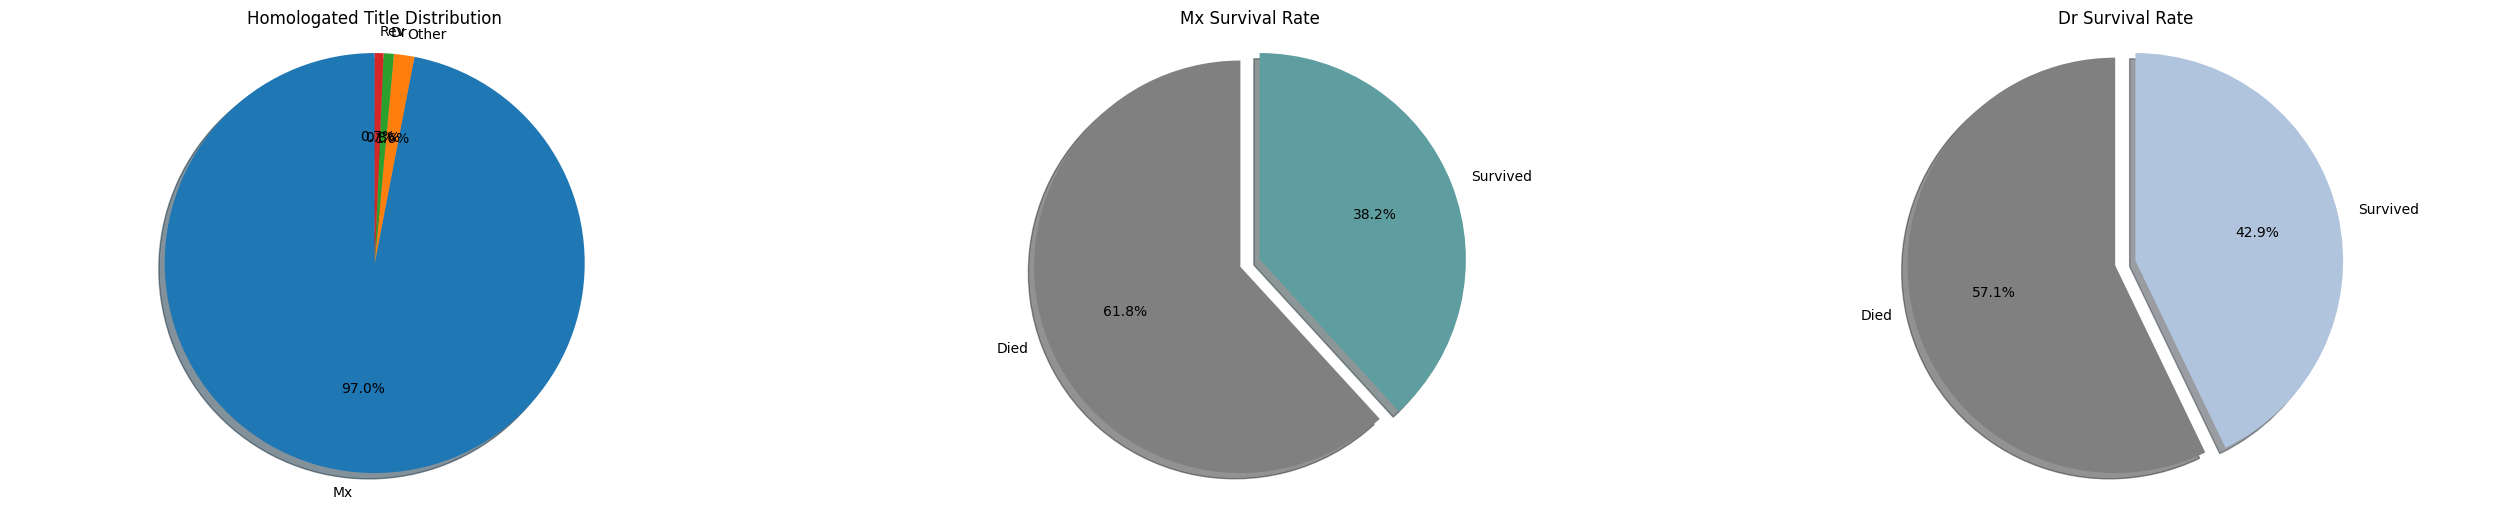

In [14]:
# Title Analysis - Checking if homologation helps

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(32, 6)

# Homologated Title Distribution
train_hom_title_distribution = train_raw["HomologatedTitle"].value_counts()

ax[0].pie(train_hom_title_distribution.values, 
          labels=train_hom_title_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%')
ax[0].axis('equal')
ax[0].set_title('Homologated Title Distribution')

# Title Distribution - Mx
train_mx_survival_distribution = train_raw[train_raw['HomologatedTitle']=='Mx'].groupby('Survived')['HomologatedTitle'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_mx_survival_distribution.values, 
          labels=train_mx_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'cadetblue'])
ax[1].axis('equal')
ax[1].set_title("Mx Survival Rate")

# Title Distribution - Dr
train_dr_survival_distribution = train_raw[train_raw['HomologatedTitle']=='Dr'].groupby('Survived')['HomologatedTitle'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_dr_survival_distribution.values,
          labels=train_dr_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[2].axis('equal')
ax[2].set_title("Dr Survival Rate")

Keeping the gender in titles is better.

### 2.6. What information can we extract from tickets numbers?

In [15]:
# Working Around Ticket Features (Letters must mean something useful)

# Split the 'Ticket' column and get the first part, then filter out numeric values
non_numeric_tickets = train_raw['Ticket'].str.split(' ').str[0][~train_raw['Ticket'].str.split(' ').str[0].str.isnumeric()]
# Display the value counts for the first 50 non-numeric ticket values
non_numeric_tickets.value_counts()

Ticket
PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
A/5.           7
SOTON/OQ       7
STON/O2.       6
CA             6
F.C.C.         5
C              5
SC/PARIS       5
S.O.C.         5
SC/Paris       4
LINE           4
A/4            3
PP             3
A/4.           3
S.O./P.P.      3
SC/AH          3
A.5.           2
A./5.          2
P/PP           2
WE/P           2
SOTON/O2       2
S.C./PARIS     2
S.W./PP        1
F.C.           1
A/S            1
SO/C           1
W/C            1
SC             1
SCO/W          1
SW/PP          1
Fa             1
S.O.P.         1
S.C./A.4.      1
A4.            1
S.P.           1
W.E.P.         1
C.A./SOTON     1
Name: count, dtype: int64

Is it helpfull knwoning if a ticket number is numeric or it has some letters? Letter are problably a way to clasify areas of the ship and therefore get a sences of survival chances with it (hypothesis)

Text(0.5, 1.0, 'Passengers With Non-Numeric Tickets Survival Rate')

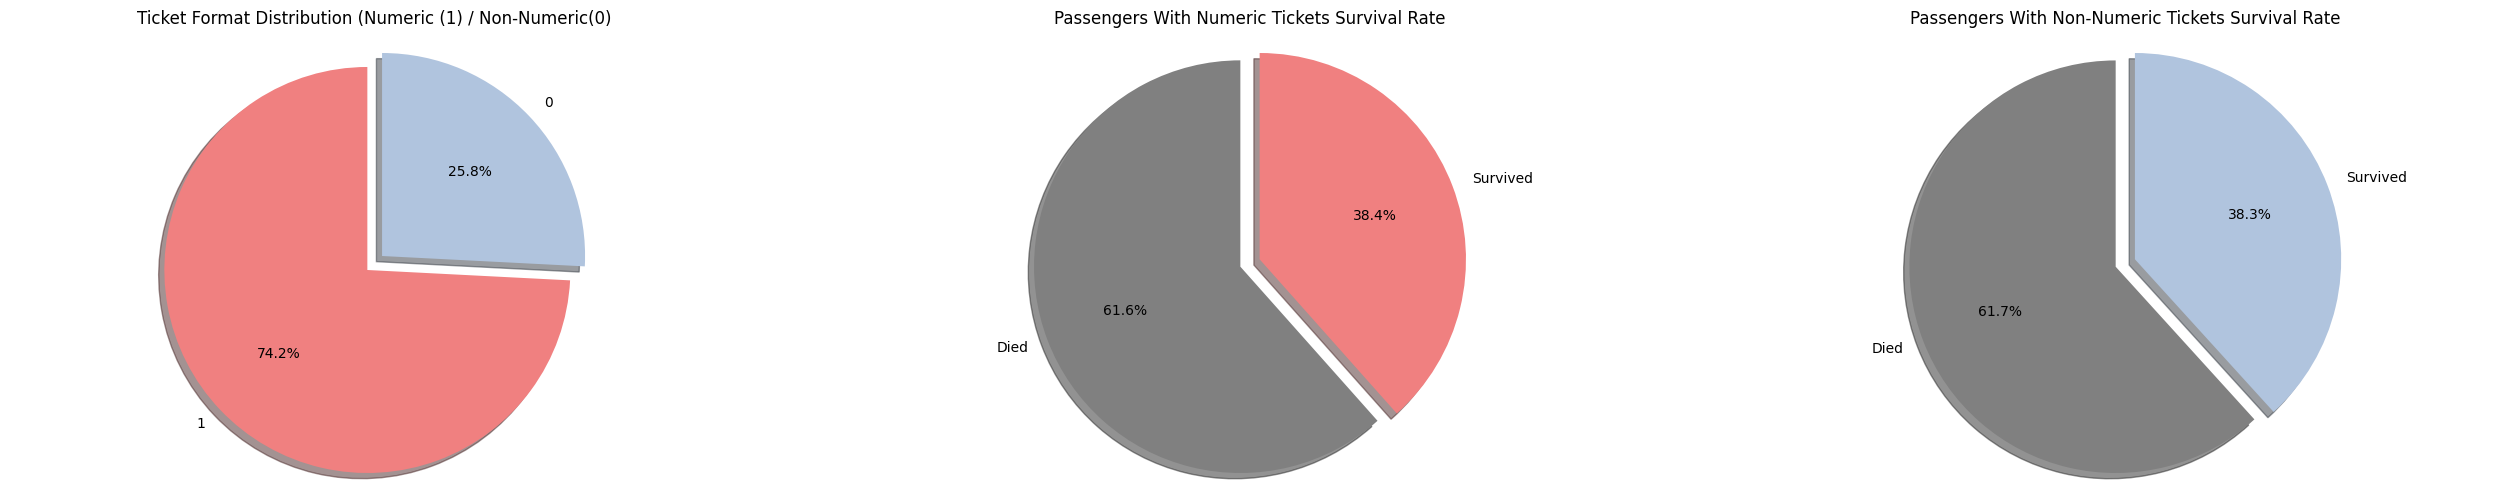

In [16]:
# Ticket Analysis

# Create a new column 'Ticket_is_numeric' with 0 for numeric and 1 for non-numeric
train_raw['NumericTicket'] = np.where(train_raw['Ticket'].str.split(' ').str[0].str.isnumeric(), 1, 0)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(32, 6)

# Ticket Numeric or Non-Numeric Distribution
train_ticket_format_distribution = train_raw["NumericTicket"].value_counts()

ax[0].pie(train_ticket_format_distribution.values, 
          labels=train_ticket_format_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['lightcoral', 'lightsteelblue'])
ax[0].axis('equal')
ax[0].set_title('Ticket Format Distribution (Numeric (1) / Non-Numeric(0)')

# Numeric Tickets Distribution
train_num_ticket_survival_distribution = train_raw[train_raw['NumericTicket']==1].groupby('Survived')['NumericTicket'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_num_ticket_survival_distribution.values, 
          labels=train_num_ticket_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[1].axis('equal')
ax[1].set_title("Passengers With Numeric Tickets Survival Rate")

# Non-Numeric Tickets Distribution
train_non_num_ticket_survival_distribution = train_raw[train_raw['NumericTicket']==0].groupby('Survived')['NumericTicket'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_non_num_ticket_survival_distribution.values, 
          labels=train_non_num_ticket_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[2].axis('equal')
ax[2].set_title("Passengers With Non-Numeric Tickets Survival Rate")

In [17]:
train_raw[train_raw['NumericTicket'] == 0]['Ticket'].str.split(' ').str[0].str.replace('.', '').str.replace('/', '').value_counts()

Ticket
PC         60
CA         41
A5         21
SOTONOQ    15
STONO      12
WC         10
A4          7
SCPARIS     7
STONO2      6
SOC         6
FCC         5
C           5
SCParis     4
LINE        4
SCAH        3
WEP         3
PP          3
SOPP        3
SOTONO2     2
SWPP        2
PPP         2
FC          1
AS          1
SP          1
SC          1
SCOW        1
Fa          1
SOP         1
SCA4        1
CASOTON     1
Name: count, dtype: int64

What about differencing between numeric tickets, PC types and others?

Text(0.5, 1.0, 'Passengers With Other Ticket Survival Rate')

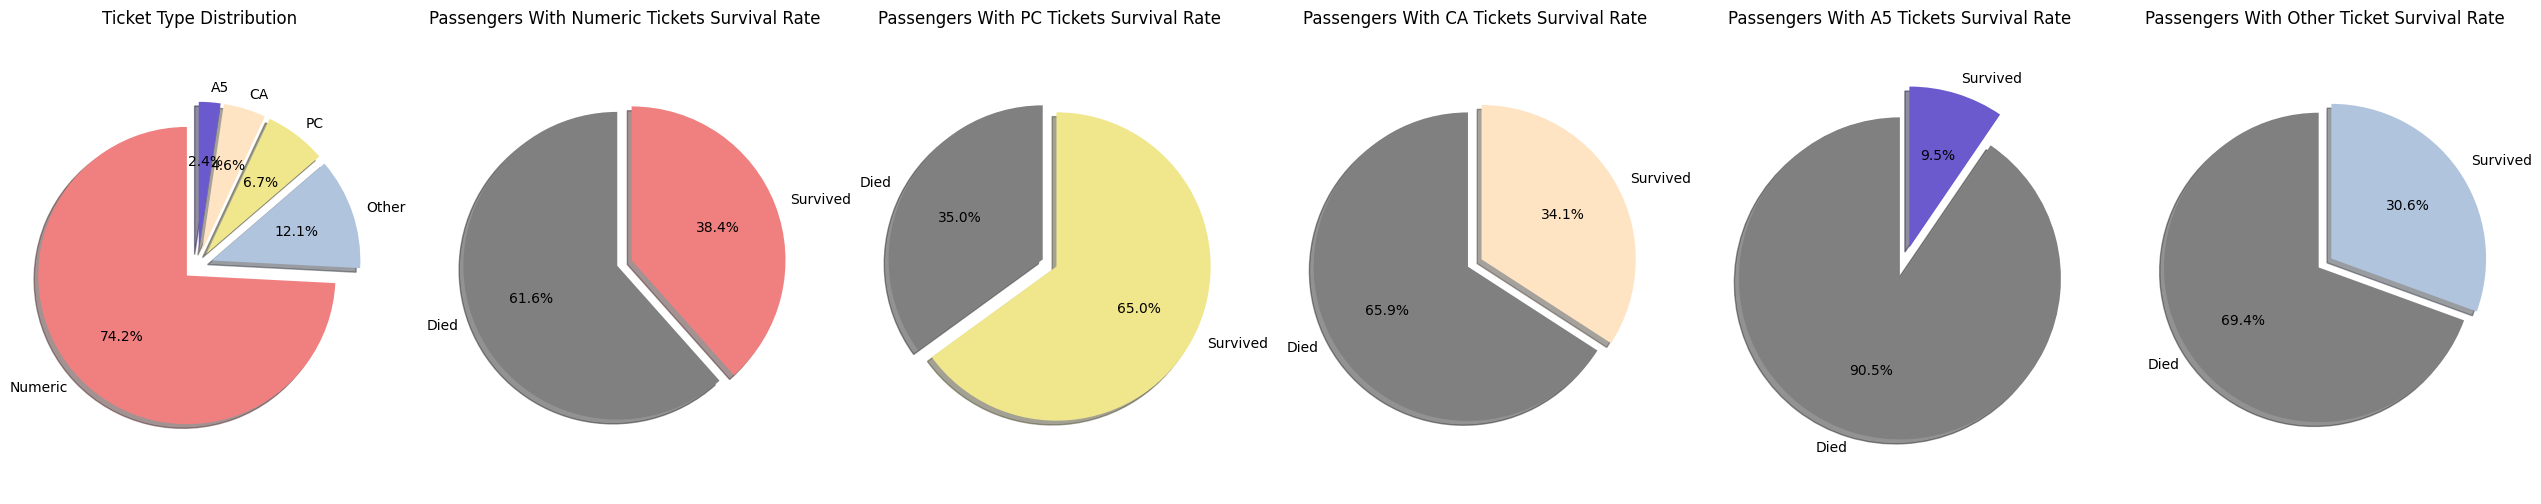

In [18]:
# Ticket Analysis

train_raw['TicketPrefix'] = train_raw['Ticket'].str.split(' ').str[0].str.replace('.', '', regex=False).str.replace('/', '', regex=False)

conditions = [
    train_raw['TicketPrefix'].str.isnumeric(),  # Numeric ticket
    (train_raw['NumericTicket'] == 0) & (train_raw['TicketPrefix'] == 'PC'),  # PC ticket
    (train_raw['NumericTicket'] == 0) & (train_raw['TicketPrefix'] == 'CA'),  # CA ticket
    (train_raw['NumericTicket'] == 0) & (train_raw['TicketPrefix'] == 'A5')  # A5 ticket
]


choices = ['Numeric', 'PC', 'CA', 'A5']
train_raw['TicketType'] = np.select(conditions, choices, default='Other')
train_raw.drop(columns=['TicketPrefix'], inplace=True) # Drop temporal column

fig, ax = plt.subplots(1, 6)
fig.set_size_inches(32, 6)

# Ticket Type Distribution
train_ticket_type_distribution = train_raw["TicketType"].value_counts()

ax[0].pie(train_ticket_type_distribution.values, 
          labels=train_ticket_type_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0.1, 0.1, 0.1, 0.1, 0.1),
          colors=['lightcoral', 'lightsteelblue', 'khaki', 'bisque', 'slateblue'])
ax[0].axis('equal')
ax[0].set_title('Ticket Type Distribution')

# Numeric Tickets Distribution
train_ticket_numeric_survival_distribution = train_raw[train_raw['TicketType']=='Numeric'].groupby('Survived')['TicketType'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_ticket_numeric_survival_distribution.values, 
          labels=train_ticket_numeric_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[1].axis('equal')
ax[1].set_title("Passengers With Numeric Tickets Survival Rate")

# PC Tickets Distribution
train_ticket_pc_survival_distribution = train_raw[train_raw['TicketType']=='PC'].groupby('Survived')['TicketType'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_ticket_pc_survival_distribution.values, 
          labels=train_ticket_pc_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'khaki'])
ax[2].axis('equal')
ax[2].set_title("Passengers With PC Tickets Survival Rate")

# CA Tickets Distribution
train_ticket_ca_survival_distribution = train_raw[train_raw['TicketType']=='CA'].groupby('Survived')['TicketType'].count().rename({0: 'Died', 1:'Survived'})

ax[3].pie(train_ticket_ca_survival_distribution.values, 
          labels=train_ticket_ca_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'bisque'])
ax[3].axis('equal')
ax[3].set_title("Passengers With CA Tickets Survival Rate")

# A5 Tickets Distribution
train_ticket_a5_survival_distribution = train_raw[train_raw['TicketType']=='A5'].groupby('Survived')['TicketType'].count().rename({0: 'Died', 1:'Survived'})

ax[4].pie(train_ticket_a5_survival_distribution.values, 
          labels=train_ticket_a5_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0.1, 0.1),
          colors=['grey', 'slateblue'])
ax[4].axis('equal')
ax[4].set_title("Passengers With A5 Tickets Survival Rate")


# Other Tickets Distribution
train_other_ticket_survival_distribution = train_raw[train_raw['TicketType']=='Other'].groupby('Survived')['TicketType'].count().rename({0: 'Died', 1:'Survived'})

ax[5].pie(train_other_ticket_survival_distribution.values, 
          labels=train_other_ticket_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[5].axis('equal')
ax[5].set_title("Passengers With Other Ticket Survival Rate")

Second option is better (Numeric|PC|Others)

### 2.7. Can Cabin values let us obtain some sense of where passengers could've been during the accident if assuming they were seleeping or at their cabins?
In this sense, passengers staying in cabins near the bottom of the ship might have had less survival chances than those in higher floors?

Text(0.5, 1.0, 'Cabin F Survival Rate')

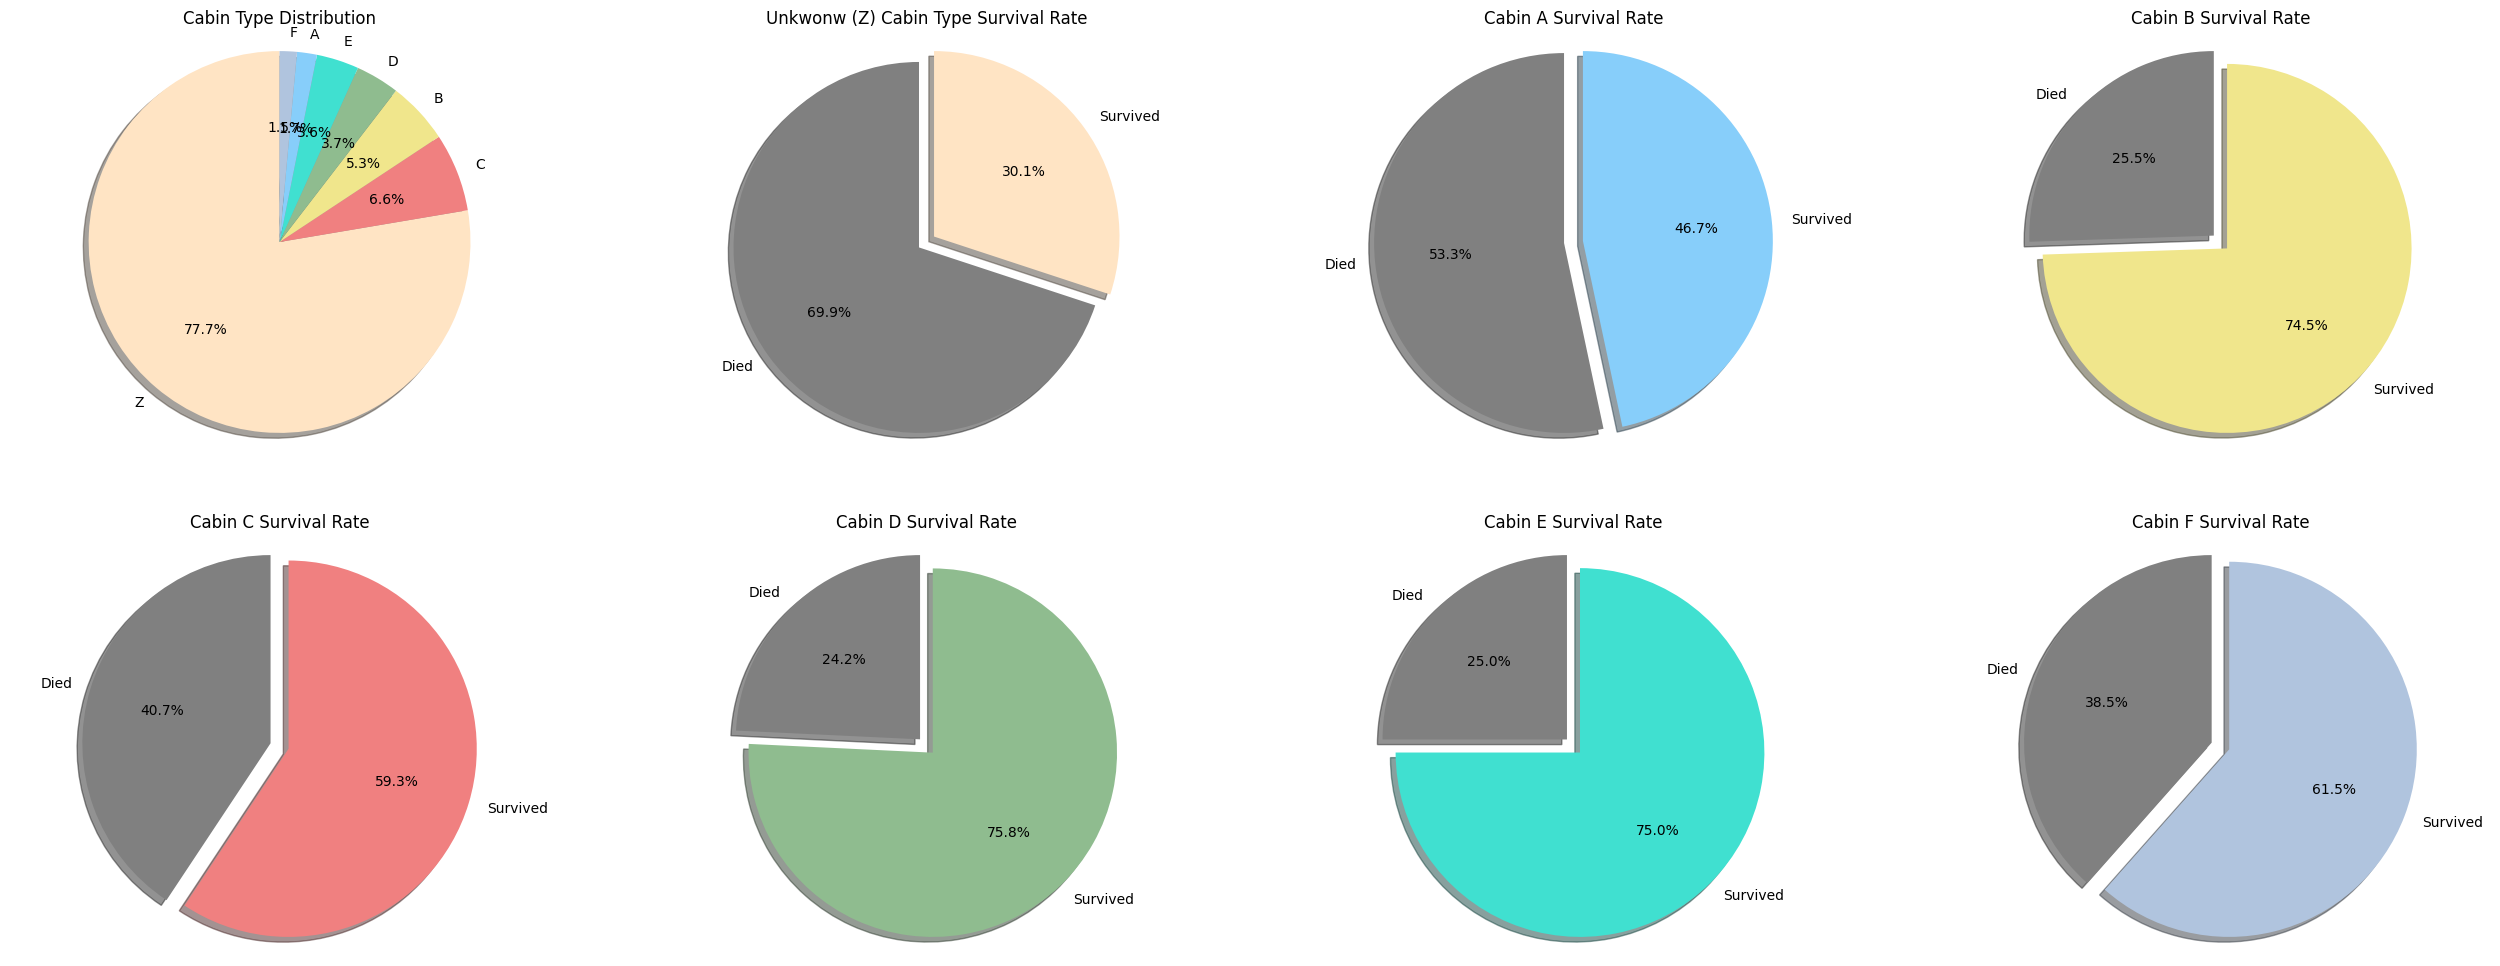

In [19]:
# Cabin Analysis

# NaN values will be 'Z' from now on. (placeholder)
# G & T will also be 'Z' from now on. --> Others
train_raw['CabinType'] = train_raw['Cabin'].fillna('Z').str[0]

# Update 'CabinType' to 'Z' if 'G' or 'T' is encountered -- Might be good to consider other possible values in test data (any new value should end up in Z class)
train_raw['CabinType'] = np.where(
    train_raw['Cabin'].str[0].isin(['G', 'T']), 
    'Z', 
    train_raw['CabinType']
)


train_raw['CabinType'].value_counts()

fig, ax = plt.subplots(2, 4)
fig.set_size_inches(32, 12)

# Cabin Type Distribution
train_cabin_type_distribution = train_raw["CabinType"].value_counts()

ax[0, 0].pie(train_cabin_type_distribution.values, 
          labels=train_cabin_type_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          colors=['bisque', 'lightcoral', 'khaki', 'darkseagreen', 'turquoise', 
                  'lightskyblue', 'lightsteelblue', 'slateblue'])
ax[0,0].axis('equal')
ax[0,0].set_title('Cabin Type Distribution')

# Unknown Cabin Type (Z) Distribution
train_unknown_cabin_survival_distribution = train_raw[train_raw['CabinType']=='Z'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[0,1].pie(train_unknown_cabin_survival_distribution.values, 
          labels=train_unknown_cabin_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'bisque'])
ax[0,1].axis('equal')
ax[0,1].set_title("Unkwonw (Z) Cabin Type Survival Rate")

# CAbin A Distribution
train_cabin_a_survival_distribution = train_raw[train_raw['CabinType']=='A'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[0,2].pie(train_cabin_a_survival_distribution.values, 
          labels=train_cabin_a_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightskyblue'])
ax[0,2].axis('equal')
ax[0,2].set_title("Cabin A Survival Rate")

# CAbin B Distribution
train_cabin_b_survival_distribution = train_raw[train_raw['CabinType']=='B'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[0,3].pie(train_cabin_b_survival_distribution.values, 
          labels=train_cabin_b_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'khaki'])
ax[0,3].axis('equal')
ax[0,3].set_title("Cabin B Survival Rate")

# CAbin C Distribution
train_cabin_c_survival_distribution = train_raw[train_raw['CabinType']=='C'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[1,0].pie(train_cabin_c_survival_distribution.values, 
          labels=train_cabin_c_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[1,0].axis('equal')
ax[1,0].set_title("Cabin C Survival Rate")

# CAbin D Distribution
train_cabin_d_survival_distribution = train_raw[train_raw['CabinType']=='D'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[1,1].pie(train_cabin_d_survival_distribution.values, 
          labels=train_cabin_d_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'darkseagreen'])
ax[1,1].axis('equal')
ax[1,1].set_title("Cabin D Survival Rate")

# CAbin E Distribution
train_cabin_e_survival_distribution = train_raw[train_raw['CabinType']=='E'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[1,2].pie(train_cabin_e_survival_distribution.values, 
          labels=train_cabin_e_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'turquoise'])
ax[1,2].axis('equal')
ax[1,2].set_title("Cabin E Survival Rate")

# CAbin F Distribution
train_cabin_f_survival_distribution = train_raw[train_raw['CabinType']=='F'].groupby('Survived')['CabinType'].count().rename({0: 'Died', 1:'Survived'})

ax[1,3].pie(train_cabin_f_survival_distribution.values, 
          labels=train_cabin_f_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[1,3].axis('equal')
ax[1,3].set_title("Cabin F Survival Rate")

### 2.7. What about the number of siblings/spouses and parents/children?

Text(0.5, 1.0, 'More parents/children Distribution')

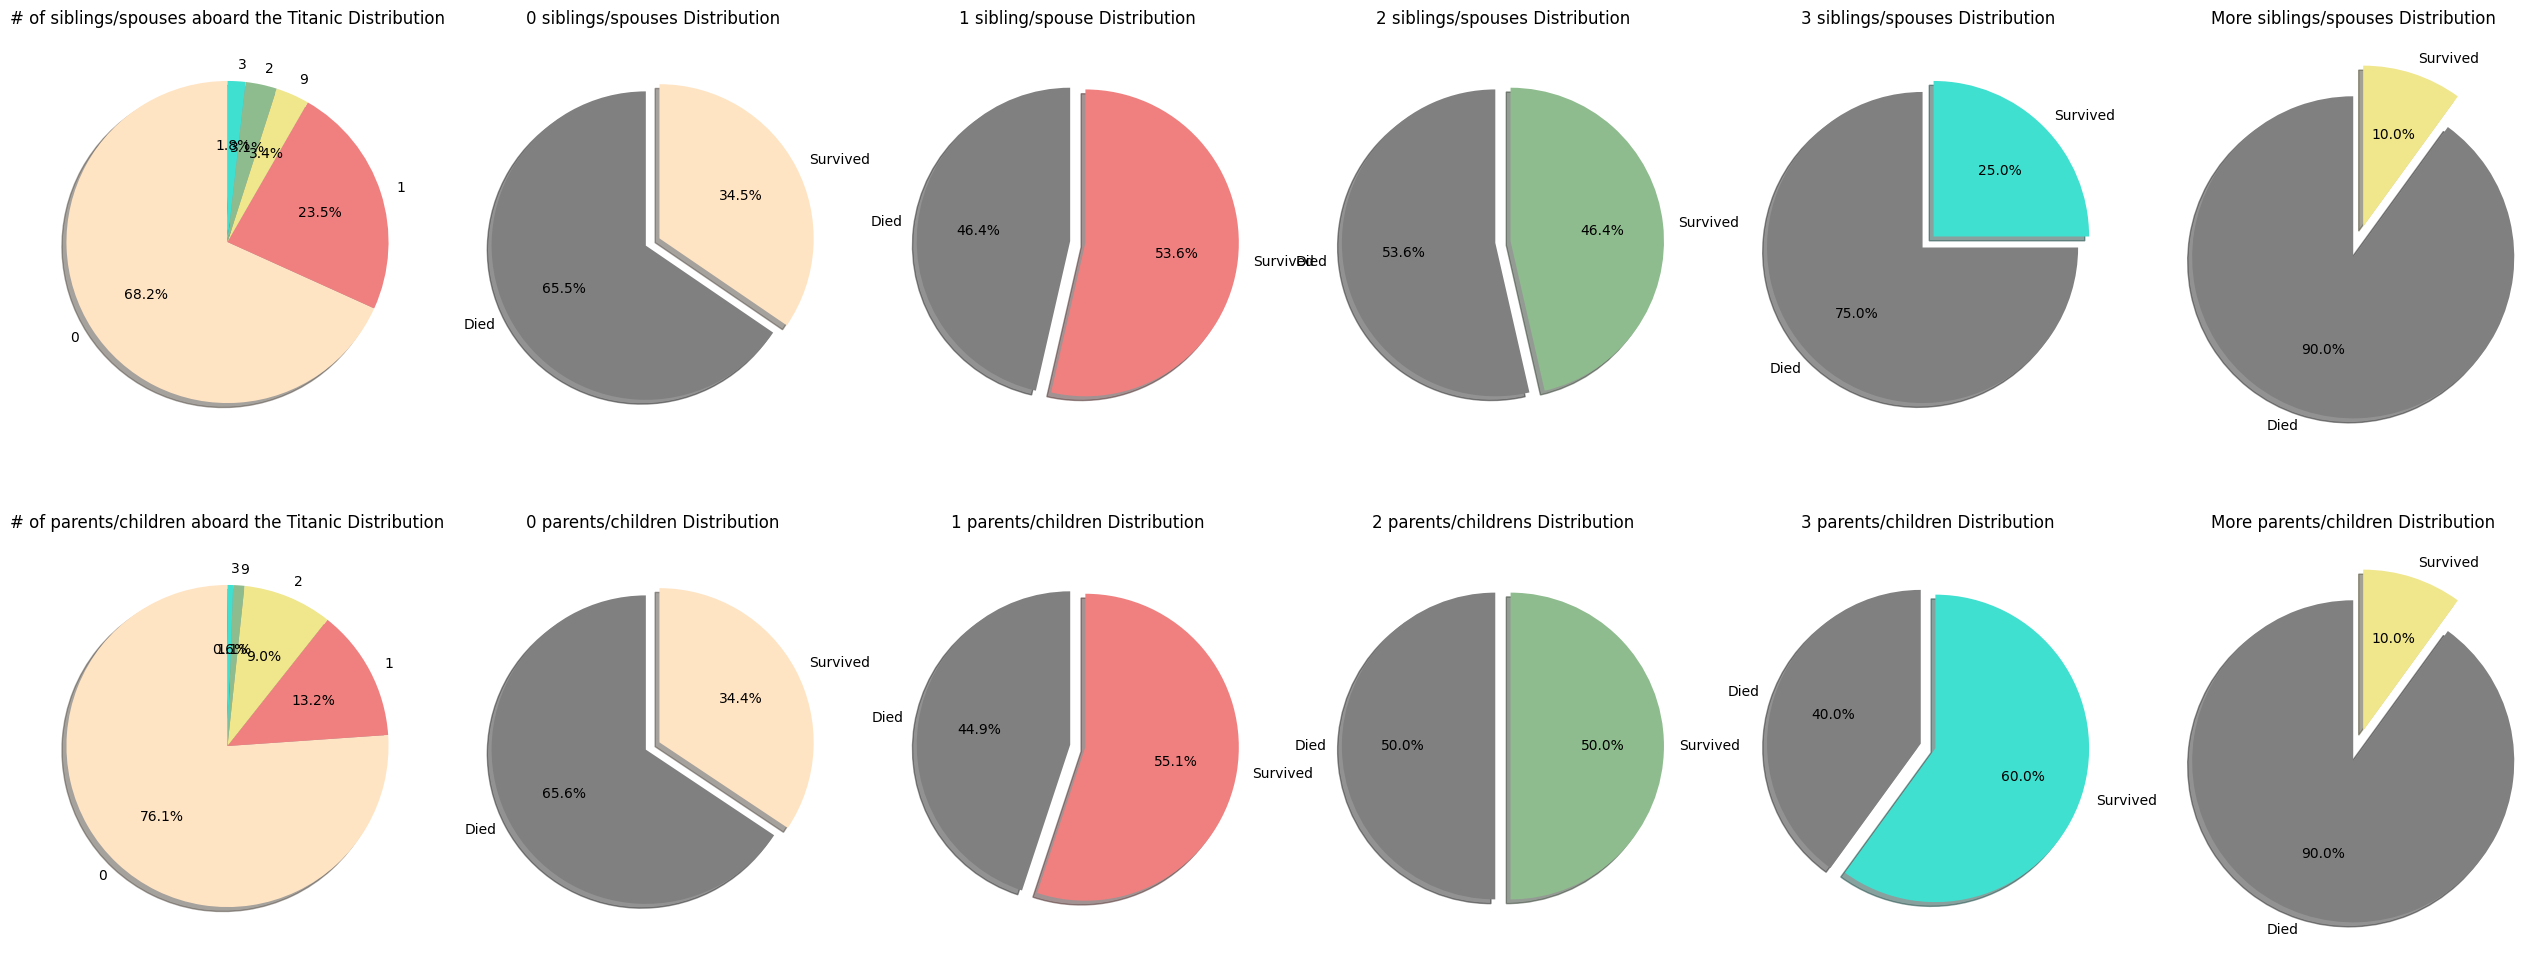

In [20]:
# Family/Company Analysis

# More than 3 will be tagged with a 9 (placeholder)
train_raw['SibSpGroup'] = np.where(
    ~train_raw['SibSp'].isin([0, 1, 2, 3]), 
    9, 
    train_raw['SibSp']
)

train_raw['ParchGroup'] = np.where(
    ~train_raw['Parch'].isin([0, 1, 2, 3]), 
    9, 
    train_raw['Parch']
)

train_raw['CabinType'].value_counts()

fig, ax = plt.subplots(2, 6)
fig.set_size_inches(32, 12)

# SibSp Group Distribution
train_sibsp_distribution = train_raw["SibSpGroup"].value_counts()

ax[0, 0].pie(train_sibsp_distribution.values, 
          labels=train_sibsp_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          colors=['bisque', 'lightcoral', 'khaki', 'darkseagreen', 'turquoise'])
ax[0,0].axis('equal')
ax[0,0].set_title('# of siblings/spouses aboard the Titanic Distribution')

# 0 siblings/spouses Distribution
train_0_sibsp_survival_distribution = train_raw[train_raw['SibSpGroup']==0].groupby('Survived')['SibSpGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[0,1].pie(train_0_sibsp_survival_distribution.values, 
          labels=train_0_sibsp_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'bisque'])
ax[0,1].axis('equal')
ax[0,1].set_title("0 siblings/spouses Distribution")

# 1 siblings/spouses Distribution
train_1_sibsp_survival_distribution = train_raw[train_raw['SibSpGroup']==1].groupby('Survived')['SibSpGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[0,2].pie(train_1_sibsp_survival_distribution.values, 
          labels=train_1_sibsp_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[0,2].axis('equal')
ax[0,2].set_title("1 sibling/spouse Distribution")

# 2 siblings/spouses Distribution
train_2_sibsp_survival_distribution = train_raw[train_raw['SibSpGroup']==2].groupby('Survived')['SibSpGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[0,3].pie(train_2_sibsp_survival_distribution.values, 
          labels=train_2_sibsp_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'darkseagreen'])
ax[0,3].axis('equal')
ax[0,3].set_title("2 siblings/spouses Distribution")

# 3 siblings/spouses Distribution
train_3_sibsp_survival_distribution = train_raw[train_raw['SibSpGroup']==3].groupby('Survived')['SibSpGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[0,4].pie(train_3_sibsp_survival_distribution.values, 
          labels=train_3_sibsp_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'turquoise'])
ax[0,4].axis('equal')
ax[0,4].set_title("3 siblings/spouses Distribution")

# More siblings/spouses Distribution
train_more_sibsp_survival_distribution = train_raw[train_raw['SibSpGroup']==9].groupby('Survived')['SibSpGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[0,5].pie(train_more_sibsp_survival_distribution.values, 
          labels=train_more_sibsp_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0.1, 0.1),
          colors=['grey', 'khaki'])
ax[0,5].axis('equal')
ax[0,5].set_title("More siblings/spouses Distribution")

# Parch Group Distribution
train_parch_distribution = train_raw["ParchGroup"].value_counts()

ax[1, 0].pie(train_parch_distribution.values, 
          labels=train_parch_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          colors=['bisque', 'lightcoral', 'khaki', 'darkseagreen', 'turquoise'])
ax[1,0].axis('equal')
ax[1,0].set_title('# of parents/children aboard the Titanic Distribution')

# 0 parents/children Distribution
train_0_parch_survival_distribution = train_raw[train_raw['ParchGroup']==0].groupby('Survived')['ParchGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[1,1].pie(train_0_parch_survival_distribution.values, 
          labels=train_0_parch_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'bisque'])
ax[1,1].axis('equal')
ax[1,1].set_title("0 parents/children Distribution")

# 1 parents/children Distribution
train_1_parch_survival_distribution = train_raw[train_raw['ParchGroup']==1].groupby('Survived')['ParchGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[1,2].pie(train_1_parch_survival_distribution.values, 
          labels=train_1_parch_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[1,2].axis('equal')
ax[1,2].set_title("1 parents/children Distribution")

# 2 parents/children Distribution
train_2_parch_survival_distribution = train_raw[train_raw['ParchGroup']==2].groupby('Survived')['ParchGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[1,3].pie(train_2_parch_survival_distribution.values, 
          labels=train_2_parch_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'darkseagreen'])
ax[1,3].axis('equal')
ax[1,3].set_title("2 parents/childrens Distribution")

# 3 parents/children Distribution
train_3_parch_survival_distribution = train_raw[train_raw['ParchGroup']==3].groupby('Survived')['ParchGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[1,4].pie(train_3_parch_survival_distribution.values, 
          labels=train_3_parch_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'turquoise'])
ax[1,4].axis('equal')
ax[1,4].set_title("3 parents/children Distribution")

# More parents/children Distribution
train_more_parch_survival_distribution = train_raw[train_raw['ParchGroup']==9].groupby('Survived')['ParchGroup'].count().rename({0: 'Died', 1:'Survived'})

ax[1,5].pie(train_more_parch_survival_distribution.values, 
          labels=train_more_parch_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0.1, 0.1),
          colors=['grey', 'khaki'])
ax[1,5].axis('equal')
ax[1,5].set_title("More parents/children Distribution")

What if we make an indicator/measure to flag passengers with/without family as company? And what about family size?

In [21]:
train_raw['FamilySize'] = train_raw['SibSp'] + train_raw['Parch'] + 1

train_raw['IsAlone'] = 0 
train_raw.loc[train_raw['FamilySize'] == 1, 'IsAlone'] = 1

train_raw[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].sample(10)

SibSp  Parch  FamilySize  IsAlone
694      0      0           1        1
608      1      2           4        0
126      0      0           1        1
549      1      1           3        0
799      1      1           3        0
469      2      1           4        0
36       0      0           1        1
813      4      2           7        0
314      1      1           3        0
44       0      0           1        1

How does being alone affect? And having company?

Text(0.5, 1.0, 'Survival Chances of Having Company')

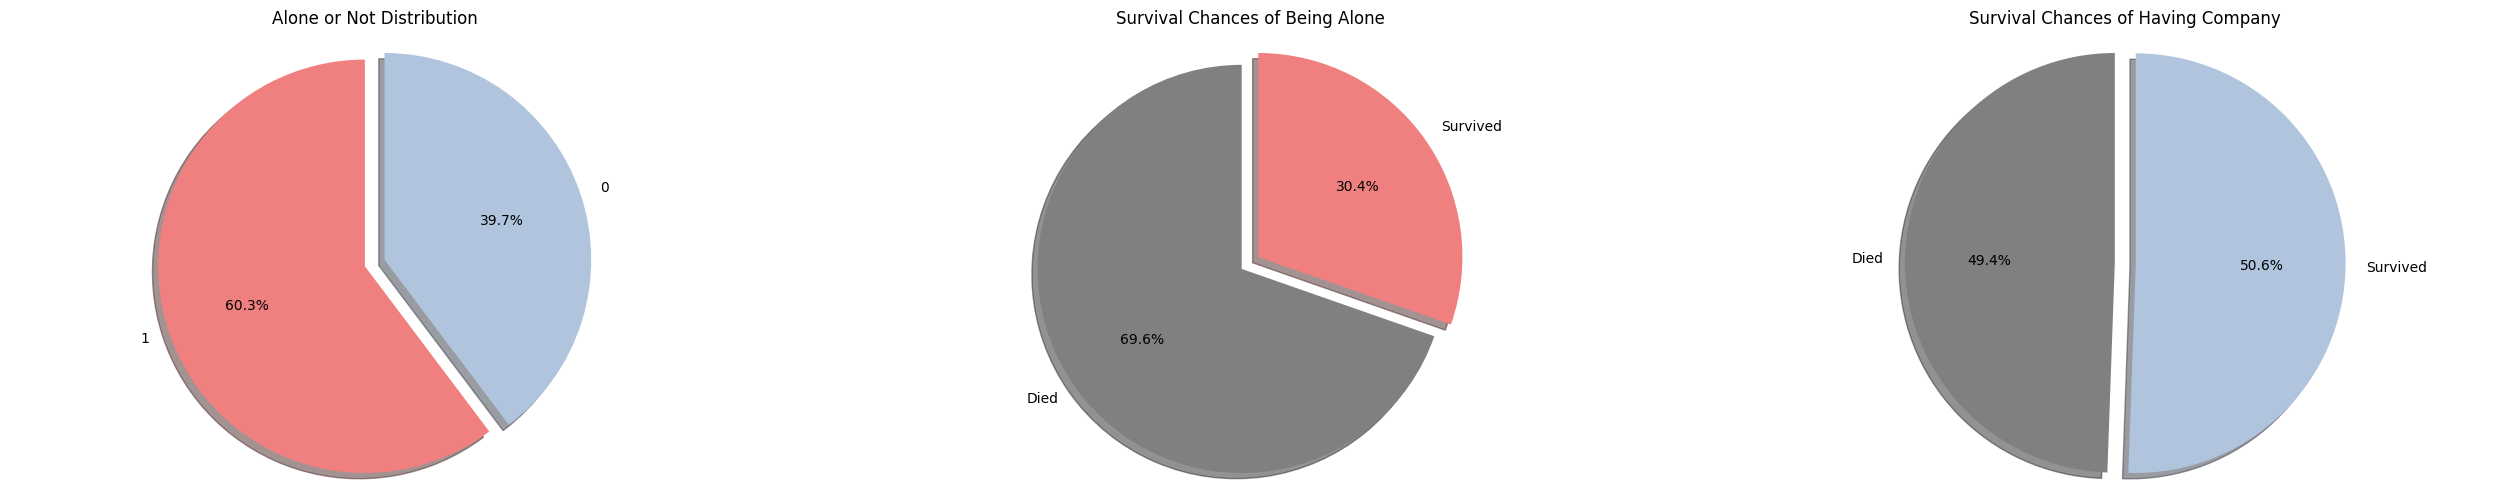

In [22]:
# Company Analysis

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(32, 6)

# Ticket Numeric or Non-Numeric Distribution
train_alone_distribution = train_raw["IsAlone"].value_counts()

ax[0].pie(train_alone_distribution.values, 
          labels=train_alone_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['lightcoral', 'lightsteelblue'])
ax[0].axis('equal')
ax[0].set_title("Alone or Not Distribution")

# Alone Distribution
train_alone_survival_distribution = train_raw[train_raw['IsAlone']==1].groupby('Survived')['IsAlone'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_alone_survival_distribution.values, 
          labels=train_alone_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[1].axis('equal')
ax[1].set_title("Survival Chances of Being Alone")

# Not Alone Distribution
train_alone_survival_distribution = train_raw[train_raw['IsAlone']==0].groupby('Survived')['IsAlone'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_alone_survival_distribution.values, 
          labels=train_alone_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightsteelblue'])
ax[2].axis('equal')
ax[2].set_title("Survival Chances of Having Company")

Data shows that being alone reduces the chances of survival.

### 2.8. What can we get from Fare values?

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


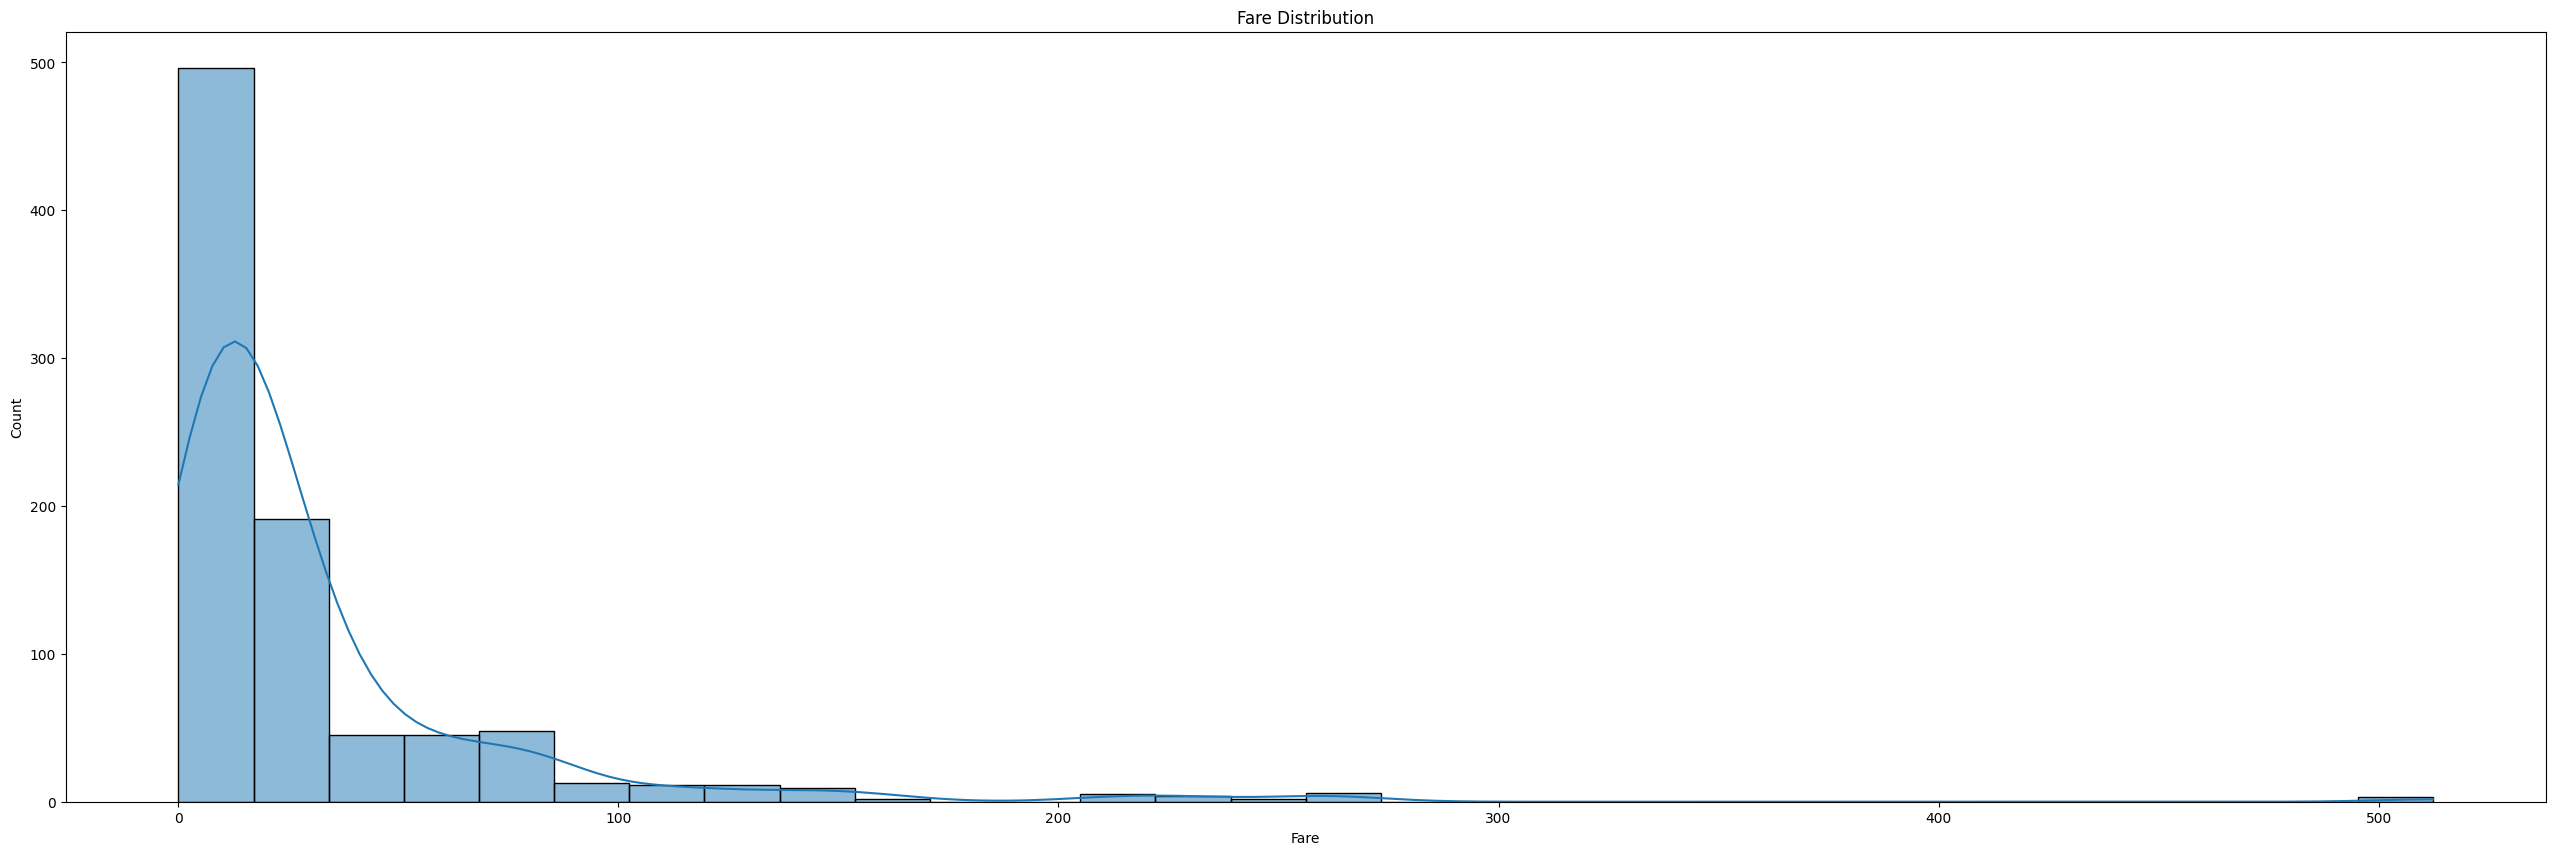

In [23]:
# Fare Analysis - Distribution

plt.figure(figsize=(32, 10))
sns.histplot(train_raw['Fare'].dropna(), kde=True, bins=30)
plt.title('Fare Distribution')
plt.show()

#### Non Uniform Bining

Text(0.5, 1.0, 'SuperHigh Fare Distribution')

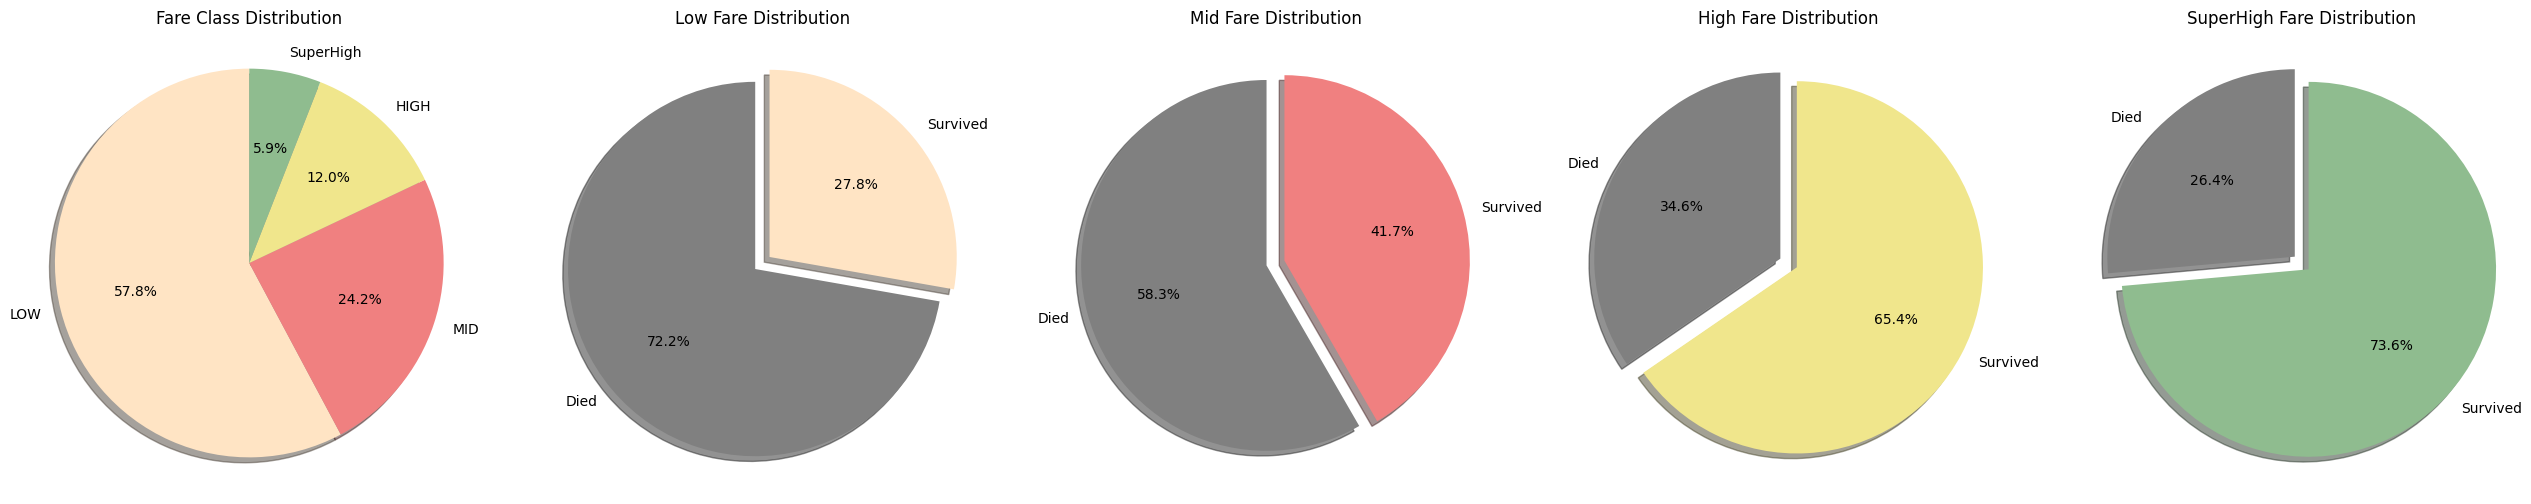

In [24]:
# Fare Analysis

# Any NaN value will be set as 0
train_raw['FareHomologated'] = train_raw['Fare'].fillna(0)
# If Fare < 0 THEN 0
train_raw['FareHomologated'] = np.where(train_raw['Fare'] < 0, 0, train_raw['Fare'])

conditions = [
    (train_raw['FareHomologated'] <= 20),  # Fare between 0 and 20
    (train_raw['FareHomologated'] > 20) & (train_raw['FareHomologated'] <= 50),  # Fare between 20 and 50
    (train_raw['FareHomologated'] > 50) & (train_raw['FareHomologated'] <= 100),  # Fare between 50 and 100
    (train_raw['FareHomologated'] > 100)  # Fare greater than 100
]

# Corresponding values for the conditions
values = ['LOW', 'MID', 'HIGH', 'SuperHigh']

# Use np.select() to create the 'FareClass' column
train_raw['FareClass'] = np.select(conditions, values, default='Unknown')


fig, ax = plt.subplots(1, 5)
fig.set_size_inches(32, 6)

# SibSp Group Distribution
train_fare_class_distribution = train_raw["FareClass"].value_counts()

ax[0].pie(train_fare_class_distribution.values, 
          labels=train_fare_class_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          colors=['bisque', 'lightcoral', 'khaki', 'darkseagreen'])
ax[0].axis('equal')
ax[0].set_title('Fare Class Distribution')

# LOW Fare Class Distribution
train_low_fare_survival_distribution = train_raw[train_raw['FareClass']=='LOW'].groupby('Survived')['FareClass'].count().rename({0: 'Died', 1:'Survived'})

ax[1].pie(train_low_fare_survival_distribution.values, 
          labels=train_low_fare_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'bisque'])
ax[1].axis('equal')
ax[1].set_title("Low Fare Distribution")

# MID Fare Class Distribution
train_mid_fare_survival_distribution = train_raw[train_raw['FareClass']=='MID'].groupby('Survived')['FareClass'].count().rename({0: 'Died', 1:'Survived'})

ax[2].pie(train_mid_fare_survival_distribution.values, 
          labels=train_mid_fare_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'lightcoral'])
ax[2].axis('equal')
ax[2].set_title("Mid Fare Distribution")

# HIGH Fare Class Distribution
train_high_fare_survival_distribution = train_raw[train_raw['FareClass']=='HIGH'].groupby('Survived')['FareClass'].count().rename({0: 'Died', 1:'Survived'})

ax[3].pie(train_high_fare_survival_distribution.values, 
          labels=train_high_fare_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'khaki'])
ax[3].axis('equal')
ax[3].set_title("High Fare Distribution")

# SuperHigh Fare Class Distribution
train_shigh_fare_survival_distribution = train_raw[train_raw['FareClass']=='SuperHigh'].groupby('Survived')['FareClass'].count().rename({0: 'Died', 1:'Survived'})

ax[4].pie(train_shigh_fare_survival_distribution.values, 
          labels=train_shigh_fare_survival_distribution.index, 
          shadow=True, 
          startangle=90, 
          autopct='%1.1f%%',
          explode=(0, 0.1),
          colors=['grey', 'darkseagreen'])
ax[4].axis('equal')
ax[4].set_title("SuperHigh Fare Distribution")

#### Uniform Bining

<ipython-input-25-f2a63a8ff4d2>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_fare_hom_survival_rate = train_raw.groupby(['FareBinHom', 'Survived']).size().unstack().dropna()


Text(0.5, 0, 'Fare Bin')

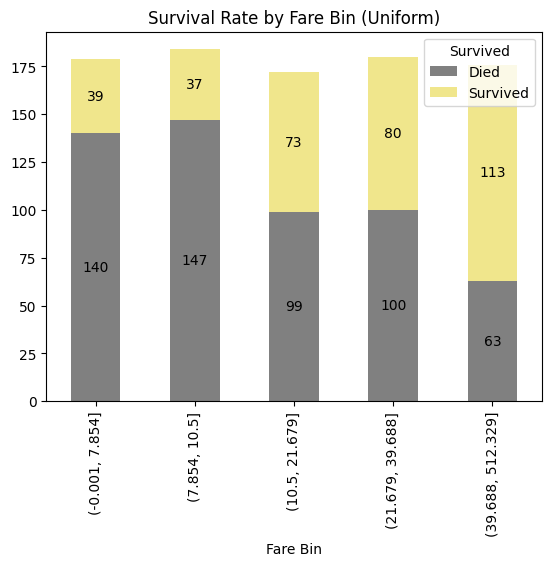

In [25]:
# Fare Analysis

train_raw['FareBinHom'] = pd.qcut(train_raw['Fare'], 5)

fig, ax = plt.subplots(1, 1)

train_fare_hom_survival_rate = train_raw.groupby(['FareBinHom', 'Survived']).size().unstack().dropna()
train_fare_hom_survival_rate = train_fare_hom_survival_rate.rename(columns={0: 'Died', 1: 'Survived'})

bars = train_fare_hom_survival_rate.plot(kind='bar', stacked=True, color=['grey', 'khaki'], ax=ax)
for container in bars.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=10, color='black')
ax.set_title("Survival Rate by Fare Bin (Uniform)")
ax.set_xlabel("Fare Bin")

Passengers with cheaper fares had less chances of survival than those with more expensive ones.

# 3. 💡 Insights

#### Gender is one of the main features in the dataset to stimate if a passenger survived or not.
#### Ticket Class helps to get better results when combined with gender.
#### Age seems a bit trickier to understand (even when combined with gender), nontheless homogeneus bining seems to be more helpful than the custom bining.
#### Passenger's Title is best when mantaining gender. Some titles are very odd so groupping them into 'Others' could be helpful for ML models.
#### Classifying tickets by numbers and letters provide some value. We might be able to clean and build other categories for better results.
#### Cabin classes could help to predict survival scenarios.
#### FamilySize or knowing if the passenger is alone could help the model a lot at estimating survival.
#### Fare bining providfes better undertanding of survival opportunities when using homogeneus groups.

# 4. ✨ Data Manipulation - Cleaning + Feature Engeneering

In [26]:
# Wrapping data manipulation in a function to ease the process of infferring new scenarios later on

def data_prep(df):

    age_avg = train_raw.groupby(['Sex', 'Title', 'Pclass'])['Age'].transform('mean') # Average age by gender (sex), title and pclass to fill na values
    fare_avg = train_raw.groupby(['Pclass', 'Title', 'Embarked'])['Fare'].transform('mean') # Average Fare by Pclass, title and Embarked
    
    # Filling missing Data
    df['Age'] = df['Age'].fillna(age_avg)
    df['Fare'] = df['Fare'].fillna(fare_avg)
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Creating New Feaures and Feature Categories
    age_bins = [0, 5, 14, 24, 33, 43, 52, 62, 69, 72, 100]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]
    df['AgeBin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    
    
    df['Title_'] = df.Name.str.split(', ').str[1].str.split('.').str[0] # Obtaining passenger's title from their names.
    # Some titles are not that common, so we will homologate them into some categories and classify the rest as 'Others'. Keep in mind that most of them are gender specific.
    title_mapping = {
        "Mr": "Mr",
        "Miss": "Miss",
        "Mrs": "Mrs",
        "Master": "Master",
        "Dr": "Dr",
        "Rev": "Rev"}
    
    df['Title'] = df['Title_'].map(title_mapping).fillna('Other')
    
    
    df['NumericTicket'] = np.where(df['Ticket'].str.split(' ').str[0].str.isnumeric(), 1, 0) # Create a new temp column 'Ticket_is_numeric' with 0 for numeric and 1 for non-numeric
    df['TicketPrefix'] = df['Ticket'].str.split(' ').str[0].str.replace('.', '', regex=False).str.replace('/', '', regex=False)
    conditions = [
        df['TicketPrefix'].str.isnumeric(),  # Numeric ticket
        (df['NumericTicket'] == 0) & (df['TicketPrefix'] == 'PC'),  # PC ticket
        (df['NumericTicket'] == 0) & (df['TicketPrefix'] == 'CA'),  # CA ticket
        (df['NumericTicket'] == 0) & (df['TicketPrefix'] == 'A5')  # A5 ticket
    ]
    choices = ['Numeric', 'PC', 'CA', 'A5']
    df['TicketType'] = np.select(conditions, choices, default='Other')
    
    
    df['CabinType'] = df['Cabin'].fillna('Z').str[0]
    df['CabinType'] = np.where(~df['Cabin'].str[0].isin(['Z', 'A', 'B', 'C', 'D', 'E', 'F']), 'Z', df['CabinType']) # Nan values or any value not in the given list will be treated as 'Z'
    
    
    df['SibSpGroup'] = np.where(~df['SibSp'].isin([0, 1, 2, 3]), 9, df['SibSp'])
    
    
    df['ParchGroup'] = np.where(~df['Parch'].isin([0, 1, 2, 3]), 9, df['Parch'])
    
    
    df['FareHomologated'] = df['Fare'].fillna(0) # Any NaN value will be set as 0
    df['FareHomologated'] = np.where(df['Fare'] < 0, 0, df['Fare']) # If Fare < 0 THEN 0
    conditions = [
        (df['FareHomologated'] <= 20),  # Fare between 0 and 20
        (df['FareHomologated'] > 20) & (df['FareHomologated'] <= 50),  # Fare between 20 and 50
        (df['FareHomologated'] > 50) & (df['FareHomologated'] <= 100),  # Fare between 50 and 100
        (df['FareHomologated'] > 100)  # Fare greater than 100
    ]
    values = ['LOW', 'MID', 'HIGH', 'SuperHigh']
    df['FareClass'] = np.select(conditions, values, default='Unknown')

    df['LnFare'] = np.log(df['Fare'] + 1)
    df['ExpFare'] = np.exp(df['Fare'] + 1)
    df['LnAge'] = np.log(df['Age'] + 1)
    df['PclassInv'] = df['Pclass'].replace({1: 3, 2: 2, 3: 1})
    df['PclassInvLn'] = np.log(df['PclassInv'])

    df['SincOfAge'] = ((np.sin(np.pi * (df['Age'] - 30))) / (np.pi * (df['Age'] - 30))).abs() # Avoiding 'bumps' before and after the global maximum colud help reducing noise. Soften the curve.

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    df['IsAlone'] = 0 
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    
    df.drop(columns=['TicketPrefix', 'NumericTicket', 'FareHomologated', 'Title_', 'Name', 'Ticket', 'Cabin'], inplace=True) # delete temp columns


In [27]:
# Import Data Again
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')

In [28]:
data_prep(train_data)

# Age and Fare Binning needs to be outside data_prep as the bins must remain the same when receiving new data --> As to not change distribution
train_data['AgeBinHom'], age_bins = pd.qcut(train_data['Age'], 7, retbins=True, duplicates='drop')
train_data['FareBinHom'], fare_bins = pd.qcut(train_data['Fare'], 5, retbins=True, duplicates='drop')

# Ordinal Encoding
categorical_cols = ['Sex', 'Embarked', 'Title', 'TicketType', 'CabinType', 'FareClass', 'AgeBinHom', 'FareBinHom']
categories = [sorted(train_data[col].dropna().unique()) for col in categorical_cols]
ordinal_encoder = OrdinalEncoder(categories=categories)
train_data[[col + 'Ordinal' for col in categorical_cols]] = ordinal_encoder.fit_transform(train_data[categorical_cols])

# One Hot Encoding
one_hot_encoder = OneHotEncoder(categories=categories[:-2], sparse_output=False, dtype=int)  # Convert to dense array
one_hot_encoded = one_hot_encoder.fit_transform(train_data[categorical_cols[:-2]])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, 
                                  columns=one_hot_encoder.get_feature_names_out(categorical_cols[:-2]), 
                                  index=train_data.index)

# Concatenate with original data
train_data = pd.concat([train_data, one_hot_encoded_df], axis=1)

encoded_age = pd.get_dummies(train_data['AgeBinHom'], prefix='AgeBinHom')
train_data = pd.concat([train_data, encoded_age], axis=1)
encoded_age.columns = [f'AgeBinHom{i+1}' for i in range(len(encoded_age.columns))]
train_data = pd.concat([train_data, encoded_age], axis=1)

encoded_fare = pd.get_dummies(train_data['FareBinHom'], prefix='FareBinHom')
train_data = pd.concat([train_data, encoded_fare], axis=1)
encoded_fare.columns = [f'FareBinHom{i+1}' for i in range(len(encoded_fare.columns))]
train_data = pd.concat([train_data, encoded_fare], axis=1)

# 4. 📈 Modeling


### 4.1. Correlation

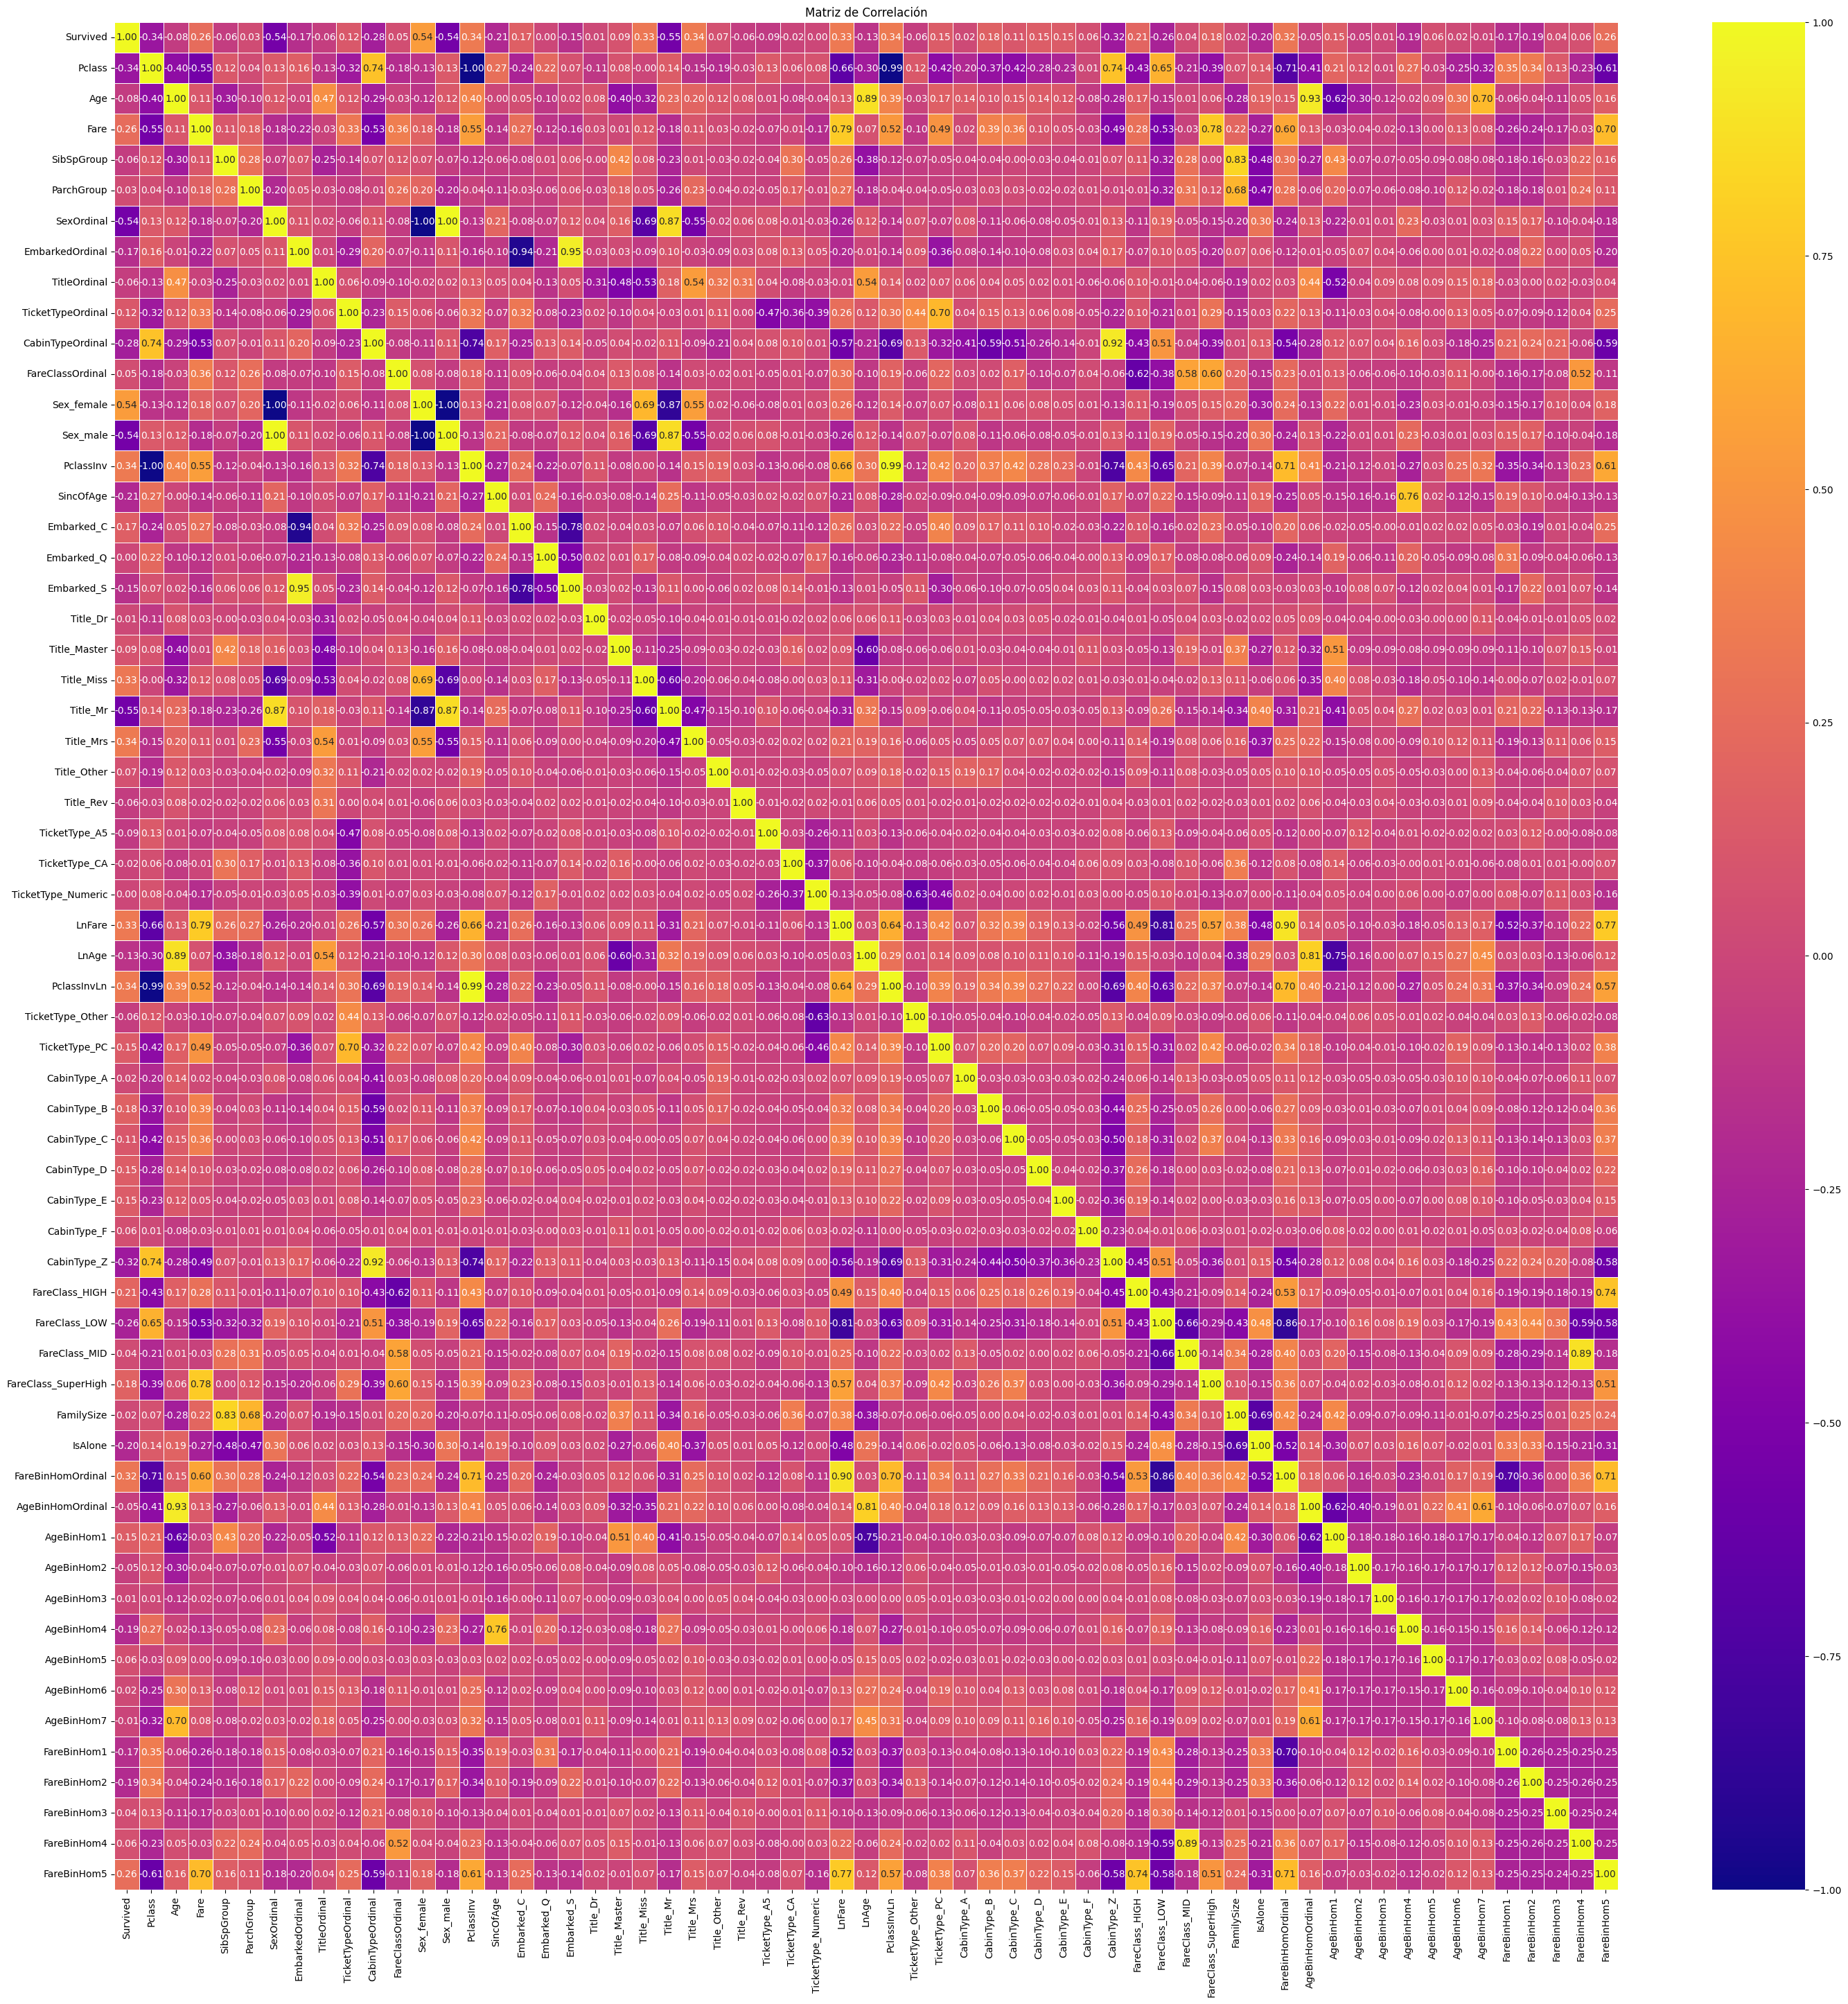

In [29]:
features_00_corr = ['Survived','Pclass', 'Age', 'Fare', 'SibSpGroup', 'ParchGroup', 'SexOrdinal', 'EmbarkedOrdinal', 'TitleOrdinal', 'TicketTypeOrdinal', 
                    'CabinTypeOrdinal', 'FareClassOrdinal', 'Sex_female', 'Sex_male', 'PclassInv', 'SincOfAge','Embarked_C', 'Embarked_Q', 'Embarked_S', 
                    'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Title_Rev', 'TicketType_A5', 'TicketType_CA', 
                    'TicketType_Numeric', 'LnFare', 'LnAge', 'PclassInvLn','TicketType_Other', 'TicketType_PC', 'CabinType_A', 'CabinType_B', 'CabinType_C', 
                    'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_Z', 'FareClass_HIGH', 'FareClass_LOW', 'FareClass_MID', 'FareClass_SuperHigh',
                    'FamilySize', 'IsAlone', 'FareBinHomOrdinal', 'AgeBinHomOrdinal', 'AgeBinHom1', 'AgeBinHom2', 'AgeBinHom3', 'AgeBinHom4', 'AgeBinHom5',
                    'AgeBinHom6', 'AgeBinHom7', 'FareBinHom1', 'FareBinHom2', 'FareBinHom3', 'FareBinHom4', 'FareBinHom5']

plt.figure(figsize=(35, 35))
sns.heatmap(train_data[features_00_corr].corr(), annot=True, cmap='plasma', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

### 4.2. Entropy
An idea to get a better understanding of which features could help the most.

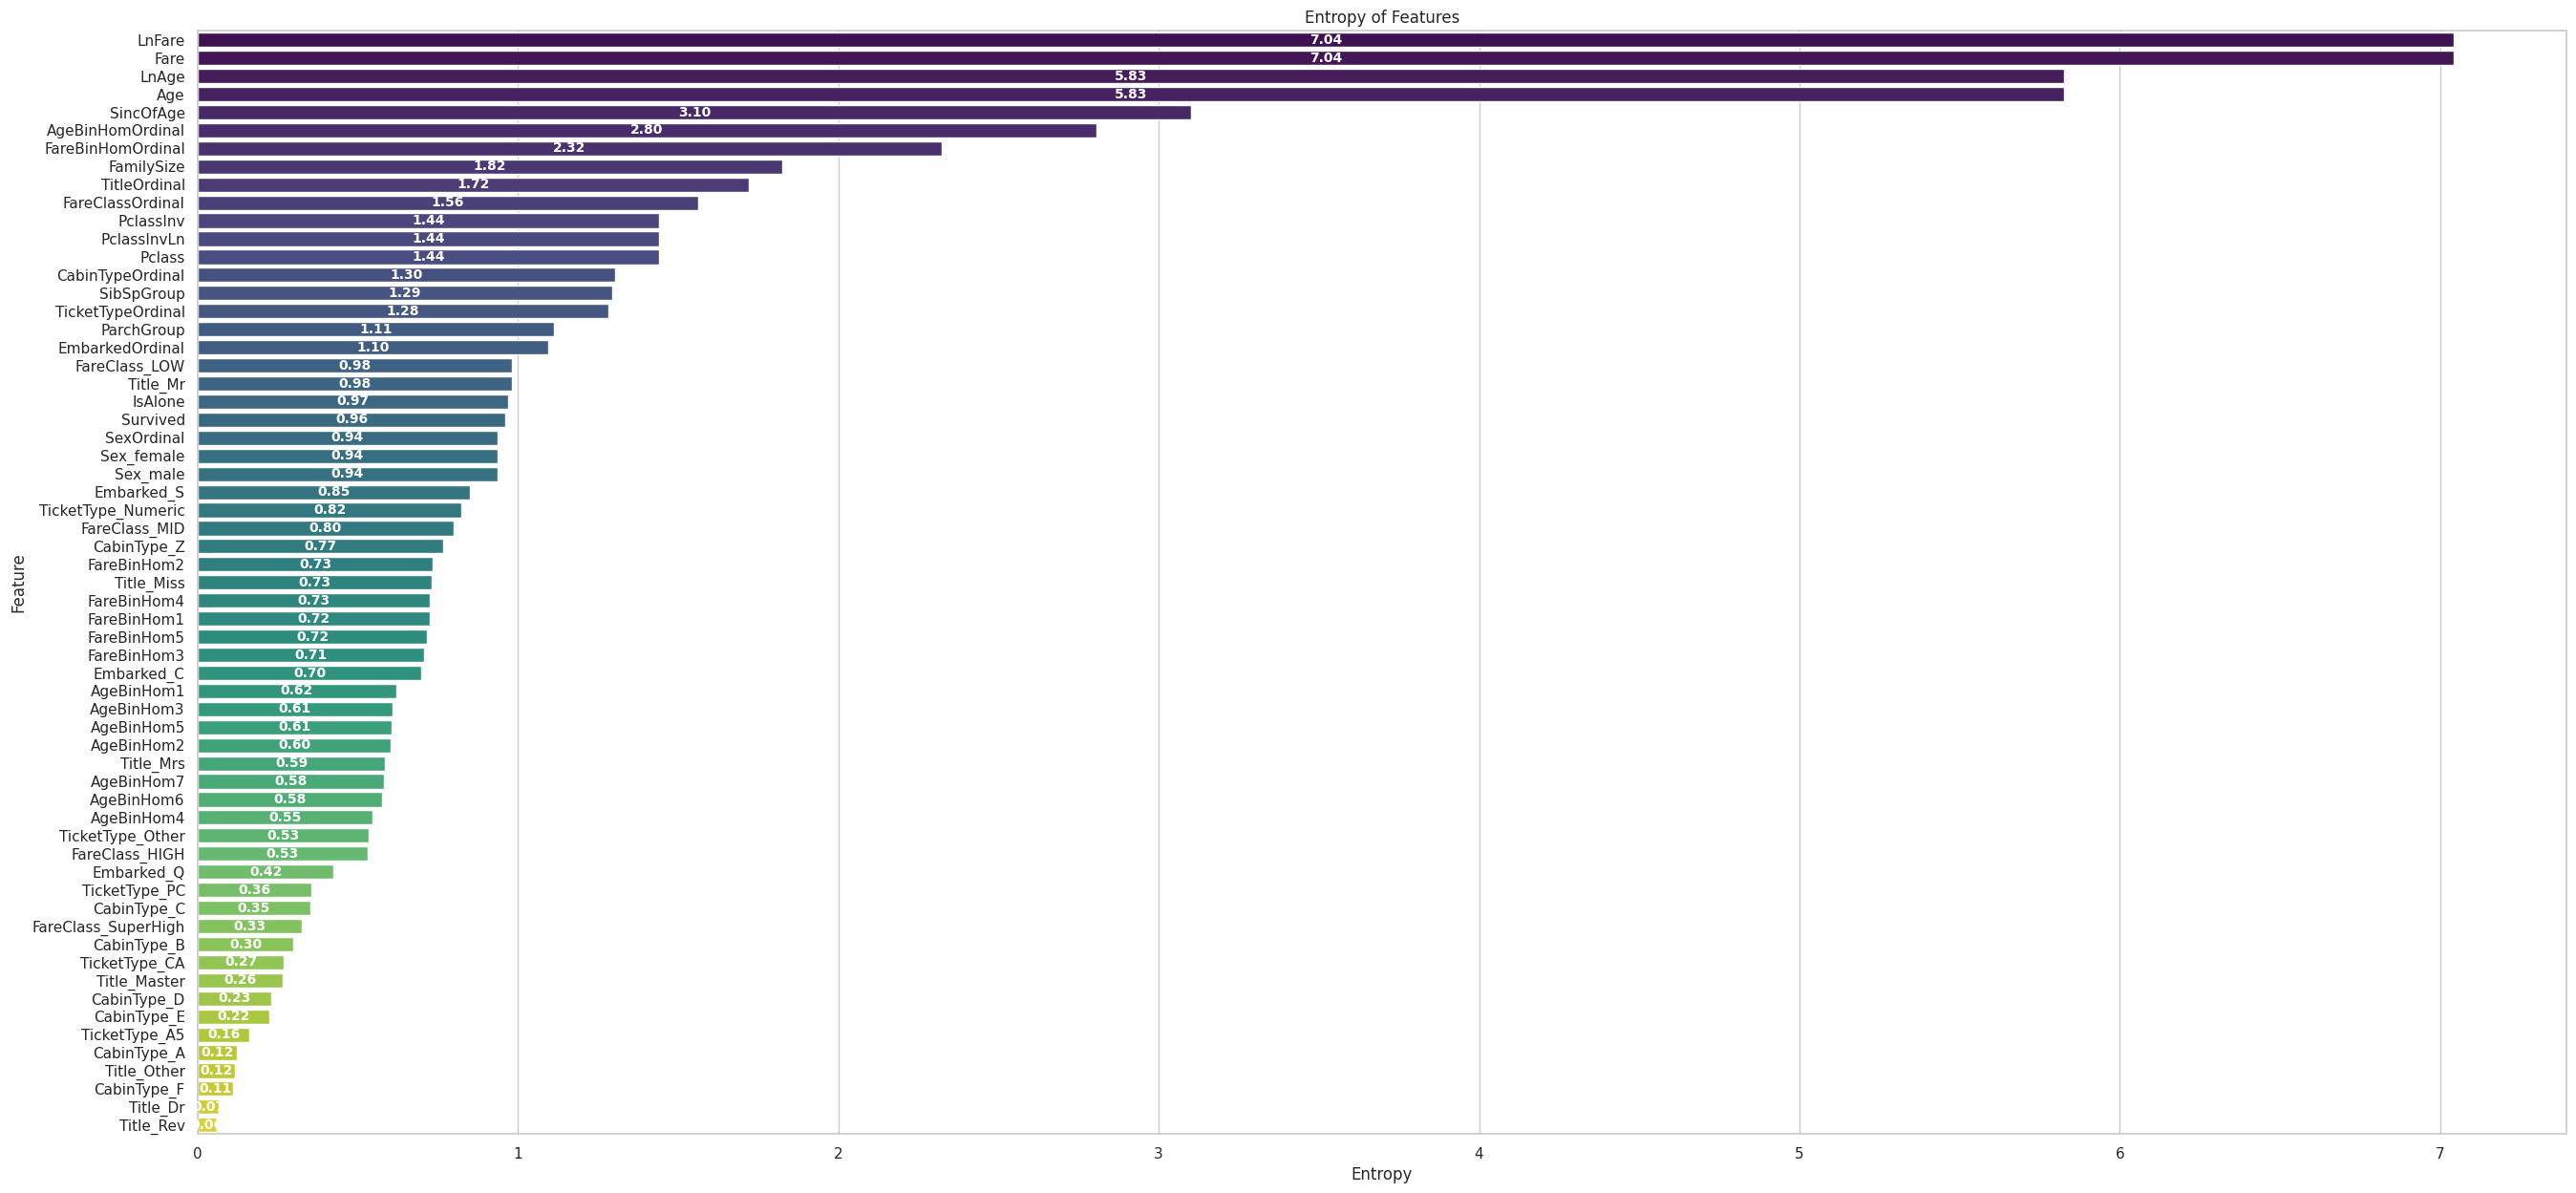

In [30]:
def calculate_entropy(feature):
    value_counts = feature.value_counts(normalize=True)
    return entropy(value_counts, base=2)

entropy_values = {}

for column in features_00_corr:
    entropy_values[column] = calculate_entropy(train_data[column])

entropy_df = pd.DataFrame(list(entropy_values.items()), columns=['Feature', 'Entropy'])
entropy_df_sorted = entropy_df.sort_values(by='Entropy', ascending=False).reset_index(drop=True)

sns.set(style="whitegrid")

plt.figure(figsize=(32, 15))
ax = sns.barplot(x='Entropy', y='Feature', data=entropy_df_sorted, palette='viridis')

plt.xlabel('Entropy')
plt.ylabel('Feature')
plt.title('Entropy of Features')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                ha='center', va='center', 
                fontsize=10, color='white', fontweight='bold')

plt.show()

In [31]:
# Features:
features_00 = ['PclassInv', 'SexOrdinal', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'CabinType_Z', 'FareClass_LOW', 'FareClass_HIGH', 
               'CabinTypeOrdinal', 'FareClass_SuperHigh', 'SibSpGroup', 'ParchGroup', 'EmbarkedOrdinal', 'LnFare', 'LnAge', 'Title_Dr'] # 83.96%

features_03 = ['PclassInv', 'SexOrdinal', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'CabinType_Z', 'FareClass_LOW', 'FareClass_HIGH', 
               'CabinTypeOrdinal', 'FareClass_SuperHigh', 'SibSpGroup', 'ParchGroup', 'EmbarkedOrdinal', 'LnFare', 'LnAge', 'Title_Dr',
               'AgeBinHomOrdinal', 'FareBinHomOrdinal', 'AgeBinHom4']

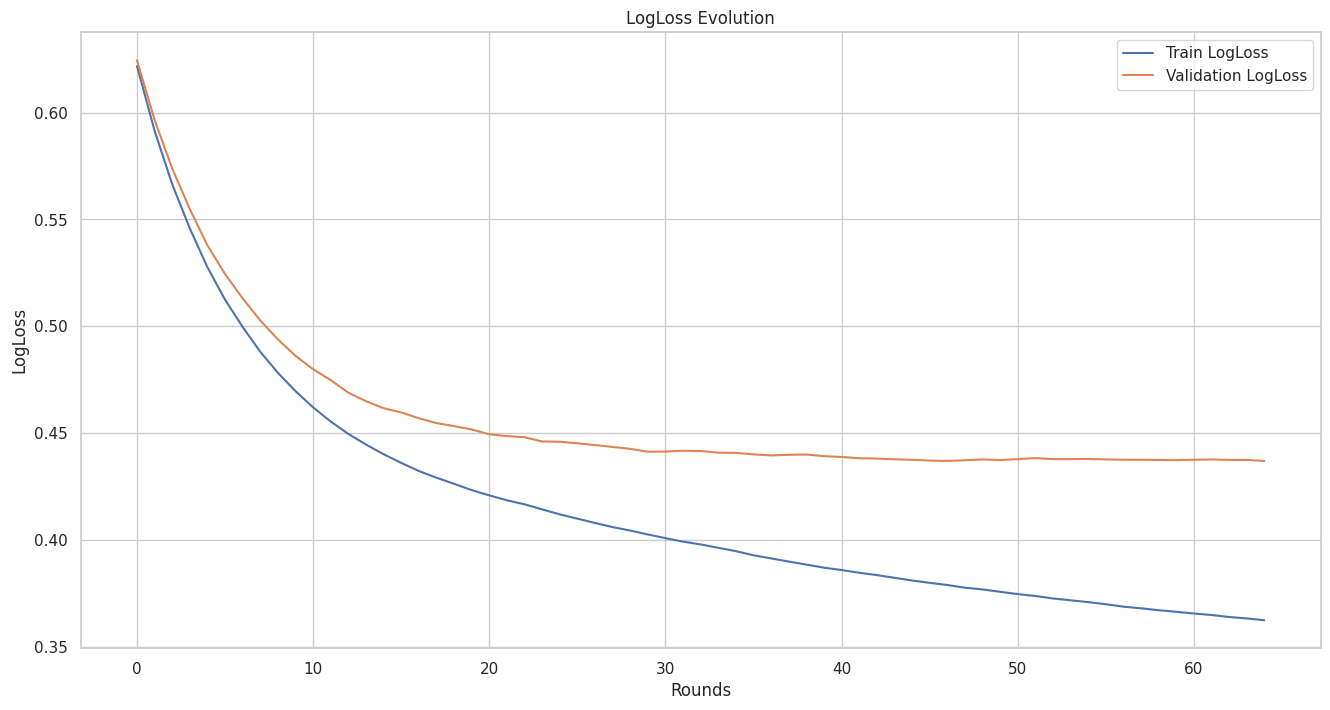

Model Accuracy: 0.8433


In [32]:
# Modeling Process

X_train, X_test, y_train, y_test = train_test_split(train_data[features_03], train_data['Survived'], test_size=0.3, random_state=42)

# Cross Validation - With KFold
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Model Hiperparameters
params = {
    'objective': 'binary:logistic',  # Para clasificación binaria
    'eval_metric': 'logloss',  # Métrica de evaluación (logloss para clasificación)
    'learning_rate': 0.1,
    'max_depth': 2,
    'seed': 42
}

train_errors = []
valid_errors = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dvalid = xgb.DMatrix(X_val_fold, label=y_val_fold)

    evals = [(dtrain, "train"), (dvalid, "valid")]
    history = {}

    model = xgb.train(params, dtrain, num_boost_round=200, evals=evals,
                      early_stopping_rounds=20, evals_result=history, verbose_eval=False)

    train_errors.append(history["train"]["logloss"])
    valid_errors.append(history["valid"]["logloss"])

min_length = min(map(len, train_errors))
train_errors = [errors[:min_length] for errors in train_errors]
valid_errors = [errors[:min_length] for errors in valid_errors]

train_errors_mean = np.mean(train_errors, axis=0)
valid_errors_mean = np.mean(valid_errors, axis=0)

plt.figure(figsize=(16, 8))
plt.plot(train_errors_mean, label="Train LogLoss")
plt.plot(valid_errors_mean, label="Validation LogLoss")
plt.xlabel("Rounds")
plt.ylabel("LogLoss")
plt.title("LogLoss Evolution")
plt.legend()
plt.show()

dtest = xgb.DMatrix(X_test)
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba >= 0.5).astype(int)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

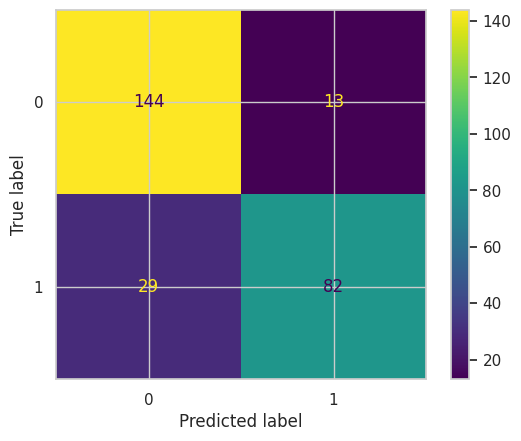

In [33]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

# 6. 🔜 Predictions

In [34]:
def find_closest_bin(value, bins):
    return min(bins, key=lambda b: abs(b.left - value))  # Find the closest left bound

# Import Data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
data_prep(test_data)

test_data['AgeBinHom'] = pd.cut(test_data['Age'], bins=age_bins, include_lowest=True)
age_bins = test_data['AgeBinHom'].cat.categories
# Identify NaN rows and assign closest bin
for idx in test_data[test_data['AgeBinHom'].isna()].index:
    age_value = test_data.loc[idx, 'Age']
    closest_bin = find_closest_bin(age_value, age_bins)
    test_data.at[idx, 'AgeBinHom'] = closest_bin

test_data['FareBinHom'] = pd.cut(test_data['Fare'], bins=fare_bins, include_lowest=True)
fare_bins = test_data['FareBinHom'].cat.categories
# Identify NaN rows and assign closest bin
for idx in test_data[test_data['FareBinHom'].isna()].index:
    fare_value = test_data.loc[idx, 'Fare']
    closest_bin = find_closest_bin(fare_value, fare_bins)
    test_data.at[idx, 'FareBinHom'] = closest_bin

# Ensure the same categorical columns as training
categorical_cols = ['Sex', 'Embarked', 'Title', 'TicketType', 'CabinType', 'FareClass', 'AgeBinHom', 'FareBinHom']

# Use the trained ordinal encoder from training data
test_data[[col + 'Ordinal' for col in categorical_cols]] = ordinal_encoder.transform(test_data[categorical_cols])

# Use the trained one-hot encoder from training data
one_hot_encoded = one_hot_encoder.transform(test_data[categorical_cols[:-2]])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, 
                                  columns=one_hot_encoder.get_feature_names_out(categorical_cols[:-2]), 
                                  index=test_data.index)

# Concatenate with original data
test_data = pd.concat([test_data, one_hot_encoded_df], axis=1)

encoded_age = pd.get_dummies(test_data['AgeBinHom'], prefix='AgeBinHom')
test_data = pd.concat([test_data, encoded_age], axis=1)
encoded_age.columns = [f'AgeBinHom{i+1}' for i in range(len(encoded_age.columns))]
test_data = pd.concat([test_data, encoded_age], axis=1)

encoded_fare = pd.get_dummies(test_data['FareBinHom'], prefix='FareBinHom')
test_data = pd.concat([test_data, encoded_fare], axis=1)
encoded_fare.columns = [f'FareBinHom{i+1}' for i in range(len(encoded_fare.columns))]
test_data = pd.concat([test_data, encoded_fare], axis=1)

# 7. 📩 Submission

In [35]:
dtest_data = xgb.DMatrix(test_data[features_03])
y_pred_raw = model.predict(dtest_data)
y_pred = (y_pred_raw >= 0.5).astype(int)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred})
output.to_csv('submission.csv', index=False)

In [36]:
output.sample(15)

PassengerId  Survived
360         1252         0
192         1084         1
316         1208         0
328         1220         0
336         1228         0
1            893         0
228         1120         0
137         1029         0
24           916         1
28           920         0
139         1031         0
7            899         0
370         1262         0
341         1233         0
86           978         1